In [2]:
import random
import numpy as np
import os
from os import path
import time
import copy
import torch
from torch import nn
from gan_training.utils4nb import return_data_test
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from gan_training import utils
from gan_training.train import Trainer, update_average
from gan_training.logger import Logger
from gan_training.checkpoints import CheckpointIO
from gan_training.inputs import get_dataset
from gan_training.distributions import get_ydist, get_zdist
from gan_training.eval_test import DisentEvaluator, Evaluator
from gan_training.config4nb import (
    load_config, build_models, build_optimizers, build_lr_scheduler,
)


In [3]:

# Arguments

#args.config_dir='./configs'
config='cells_650.yaml'
VAEname= 'FactorVAE3'
#VAEname='BetaVAE_H'
chkptname= 'last'
config_dir='./configs'
output_dir= 'Z:/COVID-FTP/Rashmi/ID-GANCheckpoints/outputs/'
#dvae_name= None
                   
name='CellCycle' #'Name of the experiment')


In [322]:

config_path = os.path.join(config_dir, config)
config = load_config(config_path)

nf=-1 #Base number of filters


bs=1 #'Batch size'
reg_param=-1 #'R1 regularization parameter'
w_info =-1#'weighting constant on ID Loss')
mi=max_iter=-1 #'Max training iteration')
num_workers=0 #'dataloader num_workers'
#batch_size=32 # help='batch size'

image_size= 256         # Generator Image size
dset_dir='F:/Rashmi/idgan-master/ProcessedData/'
dataset='CPA/CH4/' #CellCycle/Vero/LC
datatype='rgb'
nc= 3

#parser.add_argument('--img_size', default=128, type=int, help='Image synthesis size')##This is the image size for which the autoencoder is designed to


c_dim= 10 #Latent synthesis size'
z_dim=256 #type=int, help='Image synthesis size')

no_cuda=False #help='Do not use cuda')
seed=1 #type=int, help='Random Seed')
infodistil_mode=True #'Infodistill')
#args = parser.parse_args()

dvae_name='cells_trial_factor140' 
name='GAN_Trial140'

#config_path = os.path.join(config_dir, config)
#config = load_config(config_path)
is_cuda = (torch.cuda.is_available() and not no_cuda)


C:\Users\Rashmi\WorkingLibs\idgan-master_Jan\gan_training\config4nb.py:14: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [323]:
is_cuda

True

In [324]:

# = = = = = Customized Configurations = = = = = #
#output_dir='Z:/COVID-FTP/Rashmi/ID-GANCheckpoints/outputs/TrainedModels/'

checkpoint_dir = os.path.join(output_dir , name, 'chkpts')

out_dir = os.path.join(output_dir, name)



In [325]:
checkpoint_dir

'Z:/COVID-FTP/Rashmi/ID-GANCheckpoints/outputs/GAN_Trial140\\chkpts'

In [326]:
device = torch.device("cuda:0" if is_cuda else "cpu")
device

device(type='cuda', index=0)

In [327]:

# Logger
checkpoint_io = CheckpointIO(
    checkpoint_dir=checkpoint_dir
)

device = torch.device("cuda:0" if is_cuda else "cpu")

train_dataset = get_dataset(
    name='image',
    data_dir=dset_dir,
    size=image_size,
)
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=bs,
        num_workers=3,
        shuffle=True, pin_memory=True, sampler=None, drop_last=True
)



In [328]:

#Create models
fvae, generator, discriminator = build_models(image_size, c_dim, nc, z_dim)
data_loader = return_data_test(dataset, datatype, dset_dir, bs, image_size)



In [329]:
fvae

FactorVAE256(
  (encoder): Encoder256(
    (layer): Sequential(
      (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(64, 256, kernel_size=(4, 4), stride=(1, 1))
      (13): ReLU(inplace=True)
      (14): View()
      (15): Linear(in_features=256, out_features=20, bias=True)
    )
  )
  (decoder): Decoder256(
    (layer): Sequential(
      (0): Linear(in_features=10, out_features=256, bias

In [330]:
selectVAE='fvae'

if selectVAE=='dvae':
    dvae_ckpt_path =  os.path.join(output_dir, dvae_name,'chkpts', chkptname)

    dvae_ckpt = torch.load(dvae_ckpt_path)
    #for key in list(dvae_ckpt_path.keys()):
    #    dvae_ckpt_path[key.replace('decoder.', 'module.decoder.'). replace('encoder.', 'module.encoder.')] = dvae_ckpt_path.pop(key)

    dvae.load_state_dict(dvae_ckpt_path)
else:

    fvae_ckpt_path = os.path.join(output_dir, dvae_name,'chkpts', chkptname)

    fvae_ckpt = torch.load(fvae_ckpt_path)

    for key in list(fvae_ckpt['model_states']['VAE'].keys()):
        fvae_ckpt['model_states']['VAE'][key.replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.')] = fvae_ckpt['model_states']['VAE'].pop(key)


    fvae.load_state_dict(fvae_ckpt['model_states']['VAE'])

    dvae=fvae


In [331]:
output_dir

'Z:/COVID-FTP/Rashmi/ID-GANCheckpoints/outputs/'

In [332]:
# Put models on gpu if needed
dvae = dvae.to(device)
generator = generator.to(device)
discriminator = discriminator.to(device)

#g_optimizer, d_optimizer = build_optimizers(
#    generator, discriminator, dvae, config
#)

# Use multiple GPUs if possible
dvae = nn.DataParallel(dvae)
generator = nn.DataParallel(generator)
discriminator = nn.DataParallel(discriminator)

In [333]:
generator

DataParallel(
  (module): Generator(
    (fc): Linear(in_features=266, out_features=8192, bias=True)
    (resnet): Sequential(
      (0): ResnetBlock(
        (conv_0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Upsample(scale_factor=2.0, mode=nearest)
      (2): ResnetBlock(
        (conv_0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Upsample(scale_factor=2.0, mode=nearest)
      (4): ResnetBlock(
        (conv_0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (5): Upsample(scale_factor=2.0, mode=nearest)
      (6): ResnetBlock(
        (conv_0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [334]:
discriminator

DataParallel(
  (module): Discriminator(
    (conv_img): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (resnet): Sequential(
      (0): ResnetBlock(
        (conv_0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): AvgPool2d(kernel_size=3, stride=2, padding=1)
      (2): ResnetBlock(
        (conv_0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_s): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (3): AvgPool2d(kernel_size=3, stride=2, padding=1)
      (4): ResnetBlock(
        (conv_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_s): Conv2d(128, 256, kernel_size=(1, 1), strid

In [336]:

# Register modules to checkpoint
checkpoint_io.register_modules(
    generator=generator,
    discriminator=discriminator,

)

# Logger
logger = Logger(
    log_dir=path.join(out_dir, 'logs'),
    img_dir=path.join(out_dir, 'imgs'),
    #monitoring=config['training']['monitoring'],
    #monitoring_dir=path.join(out_dir, 'monitoring')
)


# Distributions
cdist = get_zdist('gauss',c_dim, device=device)
zdist = get_zdist('gauss', z_dim,
                  device=device)

 
# Save for tests
ntest = bs
#x_real, ytest = utils.get_nsamples(train_loader, ntest)
ztest = zdist.sample((ntest,))
ctest = cdist.sample((ntest,))
ztest_ = torch.cat([ztest, ctest], 1)

In [337]:

generator_test = generator

# Evaluator
dis_evaluator = DisentEvaluator(generator=generator_test, zdist=zdist, cdist=cdist,
                                batch_size=bs, device=device, dvae=dvae)
#data_loader = return_data_test()

# Train
tstart = t0 = time.time()
it = epoch_idx = -1

In [338]:
generator_test

DataParallel(
  (module): Generator(
    (fc): Linear(in_features=266, out_features=8192, bias=True)
    (resnet): Sequential(
      (0): ResnetBlock(
        (conv_0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Upsample(scale_factor=2.0, mode=nearest)
      (2): ResnetBlock(
        (conv_0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Upsample(scale_factor=2.0, mode=nearest)
      (4): ResnetBlock(
        (conv_0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (5): Upsample(scale_factor=2.0, mode=nearest)
      (6): ResnetBlock(
        (conv_0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [339]:
# Load checkpoint if existant
it = checkpoint_io.load('model.pt')
if it != -1:
    logger.load_stats('stats.p')
# Training loop

mu_real_Dump=[]
mu_gen_Dump=[]
mu_real_All=[]
mu_gen_All=[]
label1=[]
label2=[]
travN_MainDir='./outputs/TraversalLoop/'
device

=> Loading checkpoint...


device(type='cuda', index=0)

In [340]:
it

126145

In [341]:
t = time.time()

for x_true, path, label in data_loader:
    epoch_idx += 1

    #for x_real, _ in train_loader:
    
    x_true=x_true.to(device)

    mu_real, logvar, c_real = fvae(x_true, encode_only=True)
    print(c_real)
    
    recon_img=dis_evaluator.predict_image(c_real)
    recon_img=torch.stack(recon_img)
    mu_gen, logvar_gen, c_gen=fvae(recon_img, encode_only=True)
    
    mu_real_All.append(mu_real.detach().cpu())
    mu_gen_All.append(mu_gen.detach().cpu())
    
    
    mu, c_lat=dis_evaluator.predict_latent(x_true)
    Traverse=1
    if Traverse==True:
        if epoch_idx < 50:
            
            travN =  epoch_idx
            travN_dir = os.path.join(travN_MainDir, str(travN))
            #print('checkpoint_dir',checkpoint_dir)
            # Create missing directories
            if not os.path.exists(travN_dir):
                os.makedirs(travN_dir)
                
            c_lat_sample=c_lat
            z_sample=ztest[0]
            #c_lat_sample=c_lat_sample.unsqueeze(0)
            z_sample=z_sample.unsqueeze(0)
            travN
            ncol=dis_evaluator.traverse_c1z1(travN, z_sample, c_lat_sample, save='True', save_type='idgan', TravImRet='False', cmap='viridis')

## Sorting the feature tables according to order generated in the ImageGenerator 
    label1.append(label)
    label2.append(path)
    # do stuff
elapsed = time.time() - t
print('Time taken to complete testing this dataset=')
print(elapsed)

tensor([[-6.2368, -6.3693, -6.1498, -6.6806, -6.3157, -6.3445, -6.7014, -6.1301,
         -6.3957, -6.0938]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2116, -6.1646, -6.0177, -6.4153, -6.3926, -6.3781, -6.3219, -6.3850,
         -6.0014, -5.7630]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7712, -6.8148, -6.6898, -6.8630, -7.3087, -6.9275, -7.2601, -7.1556,
         -6.7468, -6.4484]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6521, -6.9083, -6.4788, -6.9151, -6.7165, -6.8220, -6.5626, -7.0032,
         -6.5208, -6.2100]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6657, -6.7172, -6.3070, -6.4203, -5.9076, -6.1016, -6.4294, -6.4243,
         -6.3009, -6.0863]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5724, -6.4608, -6.1079, -6.6789, -6.6548, -6.6060, -6.4570, -6.5892,
         -6.5877, -5.9810]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7291, -6.8604, -6.4498, -6.8112, -7.0661, -6.6488, -6.9193, -6.8988,
 

tensor([[-6.6646, -6.7486, -6.2955, -6.6982, -6.7911, -6.3720, -6.7219, -6.7037,
         -6.3825, -6.0395]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1553, -7.1546, -6.7532, -7.1109, -6.6918, -6.7482, -7.1828, -6.7533,
         -6.8382, -6.7669]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1505, -6.1890, -5.8475, -6.0795, -6.0423, -5.7273, -6.4894, -5.8990,
         -5.8774, -5.6265]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7222, -6.7710, -6.5165, -6.8643, -6.4326, -6.5881, -6.9561, -6.6193,
         -6.5460, -6.5041]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2379, -7.1634, -6.9568, -7.0576, -7.5142, -6.8737, -7.5450, -7.2822,
         -6.9819, -6.7683]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.0333, -7.0743, -6.6944, -7.1014, -7.2281, -6.9375, -7.1645, -7.2307,
         -6.7917, -6.4043]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1591, -6.1421, -5.8976, -6.2893, -6.2120, -5.9832, -6.1640, -6.3919,
 

tensor([[-6.3078, -6.3913, -6.2973, -6.4337, -6.4844, -6.3796, -6.7858, -6.5520,
         -6.3540, -6.1970]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1934, -6.1530, -6.3356, -6.4249, -6.6818, -6.4052, -6.5307, -6.4336,
         -6.3126, -6.2628]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-9.0105, -8.8189, -9.2054, -9.6853, -9.3603, -9.9621, -8.7925, -9.6207,
         -9.4146, -9.2344]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8080, -6.9152, -7.2096, -7.5654, -7.5615, -7.7038, -7.7372, -7.6111,
         -7.2606, -7.2228]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1045, -6.2829, -5.8354, -6.2328, -6.2469, -5.9748, -6.2803, -6.2332,
         -5.8743, -5.5244]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3493, -6.3638, -6.0502, -6.2456, -6.3634, -6.0067, -6.5177, -6.3883,
         -6.0827, -5.7169]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.4960, -7.3828, -7.1615, -7.3436, -7.4467, -7.0859, -7.7828, -7.4460,
 

         -6.7780, -6.2424]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2886, -6.2962, -6.2155, -6.4738, -6.2230, -6.2792, -6.0579, -6.4790,
         -6.4071, -5.9076]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3224, -6.4856, -6.0725, -6.5039, -6.3290, -6.2809, -6.2317, -6.2946,
         -6.1609, -5.8008]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4969, -6.3798, -6.2615, -6.6309, -6.6230, -6.2242, -7.0545, -6.5600,
         -6.4916, -6.1694]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9971, -6.0491, -5.7214, -6.1605, -5.9643, -6.1298, -5.9615, -6.1935,
         -5.8157, -5.4395]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5088, -6.7624, -6.2799, -6.6566, -6.6317, -6.3427, -6.6215, -6.6022,
         -6.2649, -6.0019]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9662, -6.9351, -6.4347, -7.1595, -7.0779, -6.9456, -7.1471, -6.8474,
         -6.9045, -6.5296]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-

tensor([[-6.9548, -7.1094, -6.6020, -7.0842, -7.1306, -6.7900, -6.9464, -7.2049,
         -6.8179, -6.3411]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7423, -6.9382, -6.4763, -7.0220, -6.9661, -6.8643, -6.9143, -6.8726,
         -6.6649, -6.3880]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1861, -6.5533, -5.9957, -6.5227, -6.1941, -6.1115, -6.4395, -6.0733,
         -6.1285, -5.8630]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2900, -6.4580, -6.1207, -6.4891, -6.3314, -6.2563, -6.1781, -6.5211,
         -6.2482, -5.7975]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.0088, -7.1836, -6.7863, -7.2172, -7.1586, -7.4464, -7.3633, -7.0594,
         -6.8736, -6.7857]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5181, -6.7927, -6.2430, -6.7901, -6.6277, -6.5843, -6.5133, -6.6872,
         -6.4647, -6.0302]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7208, -6.6275, -6.3689, -6.6399, -6.4084, -6.1450, -6.7180, -6.4890,
 

tensor([[-5.8343, -5.7795, -5.5470, -5.9730, -5.9397, -5.6553, -5.9274, -5.8788,
         -5.8010, -5.2355]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6960, -6.6407, -6.5016, -6.7460, -7.1849, -6.6866, -7.1555, -6.9815,
         -6.5952, -6.2249]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.4155, -7.2416, -6.9866, -7.2277, -7.6068, -6.9106, -7.5523, -7.3406,
         -7.1208, -6.7422]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.4979, -7.6055, -7.2163, -7.4467, -7.4293, -7.2808, -7.9374, -7.6060,
         -7.3205, -7.2558]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.5399, -7.6424, -7.3665, -7.3789, -7.5567, -7.4011, -7.6206, -7.7502,
         -7.1962, -7.1692]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9415, -6.9959, -6.4650, -7.0502, -7.0517, -6.8656, -6.9462, -7.0699,
         -6.7564, -6.2479]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3588, -6.1939, -6.0556, -6.1609, -6.4992, -6.0530, -6.5001, -6.2901,
 

tensor([[-6.2628, -6.2842, -6.0248, -6.1161, -6.0812, -5.8800, -6.4722, -6.0767,
         -5.9793, -5.8187]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9669, -6.2794, -6.0266, -6.2945, -6.1876, -5.9978, -6.0137, -6.2897,
         -6.0593, -5.6974]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1498, -6.2988, -5.9864, -6.4233, -6.1947, -6.1657, -6.2838, -6.2395,
         -6.0585, -5.7028]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4766, -6.7063, -6.2335, -6.3472, -5.9486, -5.9460, -6.6425, -6.5899,
         -6.3617, -6.0453]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4723, -6.7412, -6.2179, -6.6325, -6.6564, -6.4566, -6.6250, -6.7912,
         -6.2907, -5.9574]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1131, -6.0910, -5.7423, -6.2747, -6.0012, -6.0530, -6.0467, -6.3178,
         -6.1169, -5.4736]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1316, -6.3278, -5.9290, -6.2976, -6.2122, -6.0874, -6.3647, -6.2148,
 

tensor([[-5.9347, -5.9688, -5.6245, -6.1040, -5.9296, -5.8518, -5.9044, -6.1419,
         -5.9500, -5.3415]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2225, -6.3066, -6.0478, -6.3333, -6.2076, -5.7921, -6.4925, -6.0102,
         -6.0945, -5.7828]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0635, -6.0091, -5.7802, -6.0969, -6.1772, -5.9220, -6.3307, -6.2135,
         -5.9335, -5.4297]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1503, -6.2536, -6.1213, -6.4591, -6.2801, -6.2492, -6.0699, -6.3769,
         -6.3523, -5.8959]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7937, -5.8511, -5.6087, -6.0684, -5.9247, -5.9838, -5.8246, -6.0015,
         -5.6632, -5.3747]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2883, -6.3074, -6.0291, -6.0832, -6.5442, -5.9263, -6.5429, -6.3202,
         -5.9856, -5.6614]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9158, -5.8149, -5.7112, -6.0505, -5.7304, -5.9162, -5.7956, -6.2119,
 

tensor([[-6.0749, -6.2013, -6.0056, -6.2361, -6.2399, -5.8755, -6.6281, -6.2125,
         -6.1170, -5.7034]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4625, -6.3931, -6.4768, -6.6495, -7.1127, -6.4555, -7.1375, -6.8255,
         -6.5733, -6.2889]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1351, -6.8702, -6.6623, -6.8237, -7.1561, -6.5635, -7.1036, -6.8561,
         -6.7059, -6.4633]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5964, -6.8710, -6.2975, -6.4546, -6.6101, -6.6137, -6.9368, -6.6758,
         -6.1736, -6.1543]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5847, -6.5494, -6.2515, -6.3758, -6.8099, -6.4644, -6.8489, -6.5895,
         -6.2093, -5.9636]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5552, -6.4976, -6.2458, -6.7323, -6.6965, -6.4392, -6.4819, -6.4590,
         -6.5133, -6.0455]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5185, -6.6539, -6.5829, -6.6554, -6.5428, -6.2170, -6.9586, -6.5304,
 

tensor([[-5.9090, -6.1446, -5.6937, -6.2642, -6.0059, -5.9155, -6.1916, -5.9329,
         -5.9226, -5.5315]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0028, -5.7821, -5.8988, -5.8717, -6.1004, -5.5297, -6.2139, -5.9673,
         -5.8053, -5.5171]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7369, -5.8608, -5.5410, -5.8814, -5.8090, -5.5193, -5.7951, -5.9154,
         -5.6588, -5.1840]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5912, -6.4103, -7.2397, -7.3809, -7.3714, -6.9861, -7.0956, -7.0771,
         -7.1261, -7.0386]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6303, -6.6891, -6.3649, -6.9054, -6.9964, -6.9807, -7.0944, -7.0013,
         -6.6215, -6.2684]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7527, -6.7251, -6.3925, -6.8226, -7.0434, -6.6024, -6.7644, -6.7481,
         -6.4338, -6.1641]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2400, -6.3561, -6.2254, -6.3525, -6.6033, -6.3399, -6.4933, -6.4729,
 

tensor([[-5.4495, -5.6050, -5.3850, -5.7600, -5.5010, -5.6121, -5.5026, -5.8714,
         -5.5995, -5.1306]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3688, -6.3296, -6.0686, -6.5947, -6.6815, -6.3585, -6.6685, -6.5069,
         -6.3553, -5.8903]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1550, -6.0851, -5.7347, -6.2546, -6.3197, -6.0792, -6.2886, -6.2739,
         -5.9527, -5.4601]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2352, -6.3084, -5.9527, -6.4065, -6.3676, -6.1711, -6.3819, -6.3123,
         -6.1305, -5.6681]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3630, -6.2800, -6.1151, -6.4515, -6.8568, -6.3390, -6.7566, -6.4677,
         -6.2157, -5.8921]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4167, -6.5900, -6.0759, -6.6386, -6.5859, -6.5075, -6.2843, -6.6434,
         -6.2858, -5.8581]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2625, -6.4384, -5.8537, -6.4836, -6.3601, -6.2163, -6.4077, -6.4261,
 

tensor([[-5.9847, -5.9932, -5.7316, -6.1830, -6.2439, -6.1007, -6.3196, -6.2074,
         -5.8417, -5.4577]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1452, -6.1645, -5.7603, -6.3208, -6.1882, -6.0126, -6.0947, -6.2095,
         -6.0938, -5.5176]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0651, -6.0204, -5.7257, -6.2939, -6.1345, -5.9913, -6.2776, -6.1920,
         -6.2148, -5.5261]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7352, -5.7690, -5.4717, -5.8676, -5.9397, -5.5678, -5.9793, -5.7213,
         -5.5643, -5.1661]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1128, -6.2359, -5.8913, -6.1011, -6.1746, -5.7924, -6.2814, -6.1755,
         -5.8790, -5.5967]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8883, -6.0107, -5.6780, -6.1656, -5.9278, -5.9512, -5.9144, -6.1654,
         -5.8495, -5.4160]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2450, -6.1220, -5.7840, -6.2593, -6.3710, -6.0601, -6.3250, -6.3694,
 

tensor([[-6.4479, -6.3955, -6.1122, -6.1259, -5.7858, -5.8462, -6.3684, -6.0492,
         -6.0386, -5.8789]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2741, -6.3685, -5.9450, -6.4640, -6.3190, -6.0311, -6.4909, -6.2868,
         -6.2554, -5.7416]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2226, -6.3573, -6.1018, -6.4761, -6.0179, -6.1651, -6.5718, -6.0956,
         -6.2343, -5.9276]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4889, -6.3879, -6.2023, -6.2219, -5.9171, -5.7874, -6.3704, -6.2013,
         -6.2014, -6.0213]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9747, -5.8929, -5.6055, -6.0227, -5.9260, -5.7491, -5.9484, -6.0933,
         -5.9058, -5.2650]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7655, -6.8048, -6.5009, -6.7103, -7.1063, -6.8003, -6.8420, -6.7682,
         -6.4095, -6.2840]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3728, -6.3455, -6.2185, -6.5480, -5.9067, -6.0280, -6.3765, -5.8166,
 

tensor([[-6.5445, -6.6631, -6.1439, -6.6359, -6.4375, -6.1635, -6.6256, -6.4535,
         -6.4124, -5.9832]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0565, -6.0296, -6.0396, -6.3092, -6.4030, -6.2158, -6.5510, -6.2511,
         -6.0690, -5.7829]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5956, -6.7817, -6.2871, -6.6868, -6.4528, -6.2923, -6.7850, -6.4964,
         -6.3971, -6.0661]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5042, -6.6731, -6.2279, -6.7505, -6.6035, -6.3966, -6.5412, -6.5274,
         -6.4208, -6.0168]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9266, -7.1897, -6.6301, -7.1136, -7.0501, -6.8504, -7.0742, -7.1823,
         -6.8292, -6.3817]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4134, -6.3911, -6.2125, -6.2969, -6.6584, -6.1652, -6.7519, -6.4882,
         -6.1949, -5.9719]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.0185, -6.9613, -6.5983, -7.0483, -7.3541, -7.1388, -7.2752, -7.0240,
 

tensor([[-6.8081, -6.9022, -6.4951, -6.9161, -6.8699, -6.7989, -6.6548, -7.0844,
         -6.6745, -6.2105]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3524, -6.3133, -6.0978, -6.4295, -6.1519, -6.3467, -6.1723, -6.5779,
         -6.3106, -5.8021]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1837, -6.1923, -6.0162, -6.1279, -6.3075, -5.9575, -6.4530, -6.3514,
         -6.0365, -5.5827]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1352, -6.2275, -5.7837, -6.2265, -6.2170, -5.9052, -6.0951, -6.1707,
         -5.9696, -5.4677]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8682, -6.0628, -5.6367, -6.1656, -5.9290, -5.9326, -5.8809, -5.9354,
         -5.9612, -5.4373]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.3503, -7.0399, -6.8115, -7.2673, -7.0174, -6.9283, -7.3975, -6.8461,
         -6.9915, -6.8890]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9450, -5.8901, -5.9649, -6.0450, -5.7948, -5.9509, -5.8653, -6.1839,
 

tensor([[-6.6317, -6.7123, -6.3029, -6.6440, -6.4943, -6.2310, -6.8054, -6.3482,
         -6.3177, -6.1909]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9615, -5.9691, -5.6096, -6.1013, -5.9726, -5.8946, -5.8774, -6.0630,
         -5.8209, -5.3314]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1351, -6.2706, -5.9681, -6.3586, -6.2377, -5.9959, -6.0964, -6.2824,
         -6.1180, -5.6698]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5439, -6.5371, -6.2810, -6.6982, -6.5765, -6.5146, -6.3379, -6.7133,
         -6.4766, -6.0051]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6333, -5.6578, -5.7724, -5.8717, -5.6231, -5.7455, -5.7030, -6.0950,
         -5.9092, -5.4290]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6292, -5.6523, -5.7685, -5.8656, -5.6137, -5.7418, -5.6993, -6.0912,
         -5.9046, -5.4238]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8670, -6.7741, -6.5304, -6.8066, -6.9847, -6.3492, -6.9271, -6.7915,
 

tensor([[-7.3515, -7.3735, -7.3210, -7.2251, -7.8628, -7.3939, -7.4686, -7.5866,
         -7.1417, -7.0111]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7580, -6.6186, -6.3965, -6.7479, -6.9139, -6.5842, -6.9745, -6.6240,
         -6.5024, -6.1643]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9564, -6.0757, -5.6956, -6.0265, -5.9802, -5.6880, -6.0276, -5.9919,
         -5.7951, -5.4326]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0325, -6.0643, -6.2706, -6.3463, -6.6165, -6.3054, -6.7327, -6.4484,
         -6.2062, -5.9992]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3028, -6.2141, -6.2642, -6.3946, -6.6821, -6.1920, -6.5806, -6.4364,
         -6.2405, -5.9076]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3686, -6.6696, -6.2224, -6.7495, -6.4740, -6.4531, -6.5664, -6.1730,
         -6.3802, -6.0802]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.0927, -7.0952, -6.7356, -7.0362, -7.1707, -6.6060, -7.1434, -7.0299,
 

tensor([[-5.8393, -5.8509, -5.6552, -5.8904, -5.8756, -5.5562, -5.8950, -5.8640,
         -5.6223, -5.2884]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8425, -5.8501, -5.6591, -5.8922, -5.8772, -5.5593, -5.8947, -5.8639,
         -5.6237, -5.2907]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0896, -6.1299, -5.8551, -6.2638, -6.0975, -5.9920, -6.0757, -6.2862,
         -5.9972, -5.5138]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4104, -6.1746, -6.0765, -6.1784, -5.8624, -5.5198, -6.4604, -5.9340,
         -6.1533, -5.8341]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0876, -6.1262, -6.1112, -6.0769, -6.3688, -5.7284, -6.4676, -6.2193,
         -6.0487, -5.7661]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0207, -6.0055, -5.6762, -6.0398, -5.9264, -5.6697, -6.0418, -6.0223,
         -5.8614, -5.3313]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4468, -6.5289, -6.2437, -6.7129, -6.4763, -6.3538, -6.8041, -6.3261,
 

tensor([[-6.6265, -6.9066, -6.3612, -6.8623, -6.8396, -6.6329, -6.5911, -6.9090,
         -6.5052, -6.1173]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6400, -6.6889, -6.6166, -6.9378, -7.2851, -6.8618, -7.3115, -7.1500,
         -6.7177, -6.4465]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4788, -6.2700, -6.1146, -6.4484, -6.2440, -6.2866, -6.1720, -6.4812,
         -6.5332, -5.8255]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6102, -6.6618, -6.4816, -6.7746, -6.4903, -6.7201, -6.3329, -6.8026,
         -6.6394, -6.1913]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3698, -6.4401, -6.1056, -6.6316, -6.6170, -6.5849, -6.4822, -6.6298,
         -6.2461, -5.8986]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2204, -6.2955, -5.9499, -6.4783, -6.4945, -6.3002, -6.2806, -6.4124,
         -6.0892, -5.7269]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3750, -6.5436, -6.4047, -6.6925, -6.4620, -6.3461, -6.3164, -6.6775,
 

tensor([[-6.6528, -6.6699, -6.4047, -6.6435, -6.7448, -6.5310, -6.7960, -6.8098,
         -6.4203, -6.0495]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1531, -6.1989, -5.7783, -6.2325, -6.2433, -5.9477, -6.2702, -6.4104,
         -6.0602, -5.4781]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4234, -6.5289, -6.2041, -6.5939, -6.4925, -6.5678, -6.2911, -6.5032,
         -6.5587, -5.9907]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0832, -6.0308, -5.8630, -6.1817, -6.1086, -5.9569, -6.0557, -6.1216,
         -5.8724, -5.4920]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2748, -6.3367, -5.9228, -6.4365, -6.4969, -6.3572, -6.3521, -6.5594,
         -6.1022, -5.6690]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7742, -5.7060, -5.3838, -5.9055, -5.7954, -5.5639, -5.8532, -5.9255,
         -5.7676, -5.1133]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0915, -6.0440, -5.8757, -6.1945, -6.1188, -5.9698, -6.0675, -6.1339,
 

tensor([[-5.8383, -5.7050, -5.5279, -6.0303, -5.9079, -5.9743, -6.0265, -5.9044,
         -5.7758, -5.3198]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8477, -5.9926, -5.7045, -6.0103, -5.8898, -5.6097, -5.8319, -6.0415,
         -5.9230, -5.3534]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4348, -6.4078, -6.0975, -6.5864, -6.6738, -6.2662, -6.5627, -6.6519,
         -6.3933, -5.8297]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3512, -6.3570, -6.0028, -6.5168, -6.3820, -6.2722, -6.1912, -6.4861,
         -6.3565, -5.7501]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3985, -6.6820, -6.1943, -6.6341, -6.5708, -6.2927, -6.6644, -6.4761,
         -6.2712, -5.9873]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1048, -6.2112, -5.7864, -6.2558, -6.1967, -5.9310, -6.1211, -6.1698,
         -5.9732, -5.5078]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8617, -6.9449, -6.5359, -6.6878, -6.6853, -6.4304, -6.8898, -6.8129,
 

tensor([[-5.8466, -5.8711, -5.5244, -6.0112, -5.8385, -5.7808, -5.8164, -5.9201,
         -5.7834, -5.2831]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2322, -6.3345, -6.0361, -6.3186, -6.5130, -6.1674, -6.6092, -6.3656,
         -6.0836, -5.7272]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9727, -7.1540, -6.6127, -7.0478, -7.0506, -6.8842, -7.2954, -6.9753,
         -6.7534, -6.4789]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1959, -6.3177, -5.8669, -6.3014, -6.2641, -6.0154, -6.4428, -6.2381,
         -6.0048, -5.5695]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5407, -6.4257, -6.2730, -6.8045, -6.8418, -6.6916, -6.8838, -6.7022,
         -6.5096, -6.1055]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9122, -6.7724, -6.4536, -6.8539, -6.7760, -6.5624, -7.1073, -6.5050,
         -6.5659, -6.4647]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5115, -6.3361, -6.4053, -6.6434, -6.9170, -6.4411, -7.0659, -6.5092,
 

tensor([[-5.9815, -6.0194, -5.6154, -5.9848, -5.9202, -5.7563, -5.8622, -5.9826,
         -5.8150, -5.2628]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5109, -6.5414, -6.2627, -6.6260, -6.3783, -6.5057, -6.2574, -6.6956,
         -6.5154, -5.9679]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0782, -5.9649, -5.8321, -6.2248, -6.2018, -6.1119, -6.0571, -6.1808,
         -5.9137, -5.5836]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4438, -6.5803, -6.2972, -6.7139, -6.9078, -6.7852, -6.8902, -6.8683,
         -6.3886, -6.1195]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2585, -7.0987, -7.0551, -6.8655, -6.5995, -6.5012, -6.9770, -6.9703,
         -7.0350, -6.7403]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5467, -6.6452, -6.2365, -6.5481, -6.7221, -6.2950, -6.6353, -6.6143,
         -6.2223, -5.9096]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3806, -6.2950, -6.1917, -6.4351, -6.1895, -6.3455, -6.2121, -6.6565,
 

tensor([[-6.4165, -6.4542, -6.2118, -6.5591, -6.7670, -6.4944, -6.8541, -6.6214,
         -6.3185, -6.0031]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7959, -6.7264, -6.5083, -6.7075, -7.1669, -6.6886, -7.0937, -6.9456,
         -6.5683, -6.1993]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1671, -6.3543, -6.0131, -6.3047, -6.0231, -5.6969, -6.2918, -5.8897,
         -6.0511, -5.7266]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1116, -6.7128, -7.2768, -7.4996, -7.6762, -7.7513, -7.0901, -7.3855,
         -7.3429, -7.1497]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4867, -6.5329, -6.1302, -6.6279, -6.7012, -6.6517, -6.6779, -6.7456,
         -6.2686, -5.8878]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3767, -6.6784, -6.1399, -6.5546, -6.5179, -6.2813, -6.5024, -6.5776,
         -6.1886, -5.9091]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7917, -6.8986, -6.3801, -6.8707, -6.9504, -6.6928, -6.8418, -6.9707,
 

tensor([[-7.7427, -7.7687, -7.3724, -7.5928, -7.0896, -7.0233, -7.4438, -7.6380,
         -7.3766, -7.1604]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2070, -6.2433, -5.8711, -6.3498, -6.1804, -6.1380, -6.1534, -6.4572,
         -6.0998, -5.5840]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1198, -6.1366, -5.7497, -6.2483, -6.0902, -5.9791, -6.1230, -6.2732,
         -6.0190, -5.4821]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2463, -6.2827, -6.2134, -6.2971, -6.3502, -5.8110, -6.5446, -6.2078,
         -6.1894, -5.9549]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1910, -6.3185, -5.9147, -6.4705, -6.2424, -6.3284, -6.1942, -6.5345,
         -6.1586, -5.6795]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3738, -6.1138, -5.9660, -5.9737, -5.7280, -5.5579, -6.3106, -6.0570,
         -6.0678, -5.7402]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4649, -6.5333, -6.1287, -6.2442, -6.3677, -6.1070, -6.6208, -6.5536,
 

tensor([[-6.2929, -6.4382, -6.0456, -6.2706, -6.3419, -5.8643, -6.3272, -6.3548,
         -6.0293, -5.6731]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4240, -6.6896, -6.2699, -6.7719, -6.4894, -6.4340, -6.6655, -6.2801,
         -6.3900, -6.1525]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7915, -6.8443, -6.5257, -6.8711, -7.1604, -6.8214, -7.2383, -7.1578,
         -6.7429, -6.3037]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2269, -5.1468, -5.2080, -5.3458, -5.1158, -5.2777, -5.3374, -5.5876,
         -5.4332, -4.8856]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5239, -5.5455, -5.4930, -5.6930, -5.3115, -5.6995, -5.4949, -5.7673,
         -5.7265, -5.2321]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8325, -5.8029, -5.4957, -5.9749, -5.9364, -5.9800, -5.9844, -5.9454,
         -5.6056, -5.2307]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0419, -6.0374, -5.7371, -6.2704, -5.9740, -5.9875, -6.2539, -5.6617,
 

tensor([[-6.5491, -6.7713, -6.2406, -6.7285, -6.3778, -6.4876, -6.9150, -6.3616,
         -6.4153, -6.1578]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4018, -6.4443, -6.1141, -6.1115, -6.5025, -5.9245, -6.6958, -6.4710,
         -6.1537, -5.7420]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7237, -5.7693, -5.3732, -5.8547, -5.6952, -5.5972, -5.7630, -5.9140,
         -5.7076, -5.1139]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0964, -6.1722, -5.8573, -6.3175, -6.1295, -6.2210, -6.0685, -6.3784,
         -5.9335, -5.5797]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0313, -6.2049, -5.8146, -6.3706, -6.2142, -6.2280, -6.0817, -6.0504,
         -6.0208, -5.6679]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5070, -5.3394, -5.2559, -5.5523, -5.3776, -5.1435, -5.6384, -5.3814,
         -5.5540, -4.9409]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3834, -6.3217, -5.9872, -6.5594, -6.4295, -6.4717, -6.2214, -6.5406,
 

tensor([[-7.3625, -6.7551, -6.9693, -7.0410, -7.0514, -6.6052, -7.0624, -6.7951,
         -6.9934, -6.8747]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2988, -6.4241, -5.9419, -6.2848, -6.2102, -6.0380, -6.4159, -6.3724,
         -6.0436, -5.6508]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.4299, -7.3873, -7.1717, -7.2149, -7.3901, -7.1321, -7.3297, -7.4066,
         -6.9885, -6.9850]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6648, -6.6470, -6.3185, -6.7046, -6.4027, -6.5001, -7.0318, -6.4887,
         -6.5152, -6.2461]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.5972, -7.6548, -7.5200, -7.5064, -7.9702, -7.6614, -7.5579, -7.8789,
         -7.4516, -7.1944]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.3210, -7.4344, -7.0682, -7.1876, -7.2274, -7.1778, -7.6223, -7.2949,
         -7.0531, -7.0881]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.0442, -7.0118, -6.5877, -6.9310, -6.9072, -6.7814, -7.1922, -6.9544,
 

tensor([[-7.5931, -7.7153, -7.5350, -7.9360, -7.2428, -8.1074, -7.4598, -7.7267,
         -7.5929, -7.8409]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2694, -6.0188, -5.8829, -6.0396, -6.1144, -5.4919, -6.3078, -6.1073,
         -6.0631, -5.5302]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3147, -6.2634, -6.0216, -6.2616, -6.4204, -5.9718, -6.7288, -6.3320,
         -6.1907, -5.7001]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2237, -6.6604, -6.6331, -6.7504, -6.2881, -6.3089, -6.8769, -6.6253,
         -6.9291, -6.5504]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1319, -7.1374, -6.8183, -6.9854, -7.4400, -6.9751, -7.2110, -7.1959,
         -6.7685, -6.5426]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7015, -6.8863, -6.3909, -6.8084, -6.5486, -6.4242, -6.7783, -6.6095,
         -6.4214, -6.2523]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4129, -6.3803, -6.4814, -6.5985, -6.6184, -6.2999, -6.7642, -6.4228,
 

tensor([[-6.4799, -6.5988, -6.2248, -6.7546, -6.5987, -6.5761, -6.6193, -6.5664,
         -6.3395, -5.9878]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7326, -6.7059, -6.5988, -6.9600, -7.2335, -6.9796, -7.0708, -7.0405,
         -6.6687, -6.4176]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2143, -7.4190, -6.8077, -7.1196, -6.4982, -7.2122, -7.4705, -7.0709,
         -6.8455, -6.9689]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2129, -7.4158, -6.8071, -7.1185, -6.4969, -7.2104, -7.4686, -7.0693,
         -6.8432, -6.9672]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7300, -6.5405, -6.6033, -6.9326, -6.9747, -6.5827, -7.0824, -6.7959,
         -6.7468, -6.4040]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6400, -6.7459, -6.2885, -6.8729, -6.7236, -6.6011, -6.7817, -6.6787,
         -6.5558, -6.1065]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.4086, -7.1893, -7.1188, -7.3368, -7.4524, -7.0132, -7.7517, -7.3153,
 

tensor([[-7.0394, -6.7208, -6.8993, -7.3111, -6.8347, -7.0932, -7.1833, -6.8323,
         -7.0759, -6.9900]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8075, -6.9250, -6.7201, -6.6926, -6.3510, -6.5495, -7.0391, -6.8520,
         -6.7091, -6.5789]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2002, -7.2844, -6.9503, -6.9229, -6.8907, -6.7840, -7.0951, -7.2021,
         -6.8997, -6.8194]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.1642, -8.4521, -7.9723, -8.0280, -7.0754, -7.6639, -7.5059, -8.2039,
         -8.0137, -7.8443]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8867, -6.8710, -6.9141, -6.9398, -7.3221, -7.0345, -7.3895, -7.3526,
         -7.0129, -6.7402]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.4910, -7.3339, -7.0510, -7.1529, -6.6811, -6.5962, -7.3095, -7.2970,
         -7.1843, -6.9572]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1266, -6.9788, -6.7306, -6.7868, -6.7927, -6.4328, -7.1332, -6.9882,
 

tensor([[-6.4439, -6.3450, -5.9908, -6.4898, -6.4848, -6.2575, -6.3464, -6.6034,
         -6.3154, -5.6949]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8972, -6.0483, -5.6532, -6.1078, -6.0428, -5.8534, -5.9808, -6.1223,
         -5.7846, -5.3591]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3622, -6.2366, -5.9294, -6.3064, -6.2770, -6.1652, -6.1818, -6.4220,
         -6.2263, -5.6213]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7264, -6.8472, -6.4462, -6.8939, -6.8947, -6.6791, -6.6891, -6.8778,
         -6.4717, -6.1676]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4043, -6.3939, -6.0001, -6.2286, -6.3047, -5.9043, -6.5544, -6.2099,
         -6.0201, -5.6913]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5063, -6.5443, -6.1387, -6.7075, -6.5602, -6.4994, -6.3573, -6.6260,
         -6.4581, -5.9077]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5256, -6.4573, -6.5134, -6.7022, -6.4112, -6.6646, -6.2778, -6.6991,
 

tensor([[-6.7319, -6.5256, -6.2263, -6.8014, -6.9646, -6.6319, -6.6493, -6.6635,
         -6.5810, -6.0988]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2006, -6.2272, -6.1789, -6.3944, -6.5853, -6.2901, -6.5485, -6.4120,
         -6.1193, -5.8887]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5028, -6.8119, -6.3233, -6.5392, -5.9861, -6.3152, -6.7837, -6.4300,
         -6.3451, -6.2252]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0296, -6.1932, -5.9118, -6.2720, -6.2669, -6.0340, -6.1540, -6.1253,
         -5.8378, -5.6052]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2561, -6.3420, -5.9839, -6.4366, -6.3800, -6.1691, -6.1402, -6.3273,
         -6.1487, -5.7026]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2985, -6.2240, -5.9532, -6.2111, -6.0689, -5.8349, -6.5780, -5.9791,
         -6.0410, -5.7662]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2961, -6.2938, -5.8976, -6.0717, -6.1549, -5.6124, -6.4020, -6.1684,
 

tensor([[-6.5074, -6.4909, -6.0299, -6.5480, -6.5685, -6.2433, -6.5072, -6.5324,
         -6.3180, -5.7784]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8488, -5.8346, -5.5461, -5.9847, -5.8837, -5.7951, -5.8026, -5.9610,
         -5.7635, -5.2542]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5655, -6.7487, -6.2310, -6.8082, -6.6869, -6.6482, -6.5241, -6.8020,
         -6.3876, -6.0022]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2760, -6.3046, -6.3961, -6.5302, -6.2579, -6.4010, -6.1857, -6.5939,
         -6.5029, -6.1011]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2185, -6.3616, -5.9874, -6.2514, -6.1971, -5.8534, -6.2913, -6.0827,
         -5.8893, -5.7271]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5627, -5.5491, -5.3523, -5.7426, -5.6944, -5.3108, -5.7545, -5.6597,
         -5.6072, -5.0240]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2931, -6.4660, -5.9607, -6.4542, -6.3802, -6.1029, -6.4316, -6.2741,
 

tensor([[-6.5729, -6.6478, -6.2000, -6.4317, -6.7774, -6.1785, -6.9129, -6.7191,
         -6.3829, -5.9905]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4811, -6.6959, -6.3119, -6.6561, -6.5899, -6.5117, -6.5166, -6.9350,
         -6.4501, -6.0031]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1308, -6.4218, -6.1183, -6.4078, -6.4538, -6.3028, -6.3348, -6.3949,
         -5.9048, -5.8106]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0262, -6.1957, -5.7451, -6.2065, -6.3050, -5.9530, -6.1135, -6.1591,
         -5.8623, -5.5148]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6420, -6.5694, -6.2739, -6.4408, -6.7069, -6.2007, -6.8347, -6.6246,
         -6.3111, -5.9278]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5456, -6.7476, -6.2599, -6.7755, -6.5887, -6.6927, -6.4455, -6.5962,
         -6.5761, -6.0652]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3014, -6.4125, -5.8989, -6.3238, -6.3209, -6.0611, -6.4242, -6.3844,
 

tensor([[-6.2316, -6.4812, -6.0663, -6.5718, -6.3560, -6.3401, -6.1998, -6.3111,
         -6.2516, -5.8734]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4463, -5.6292, -5.4503, -5.6004, -5.5228, -5.4468, -5.5690, -5.7759,
         -5.3844, -5.0827]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8199, -5.8348, -5.5471, -5.8226, -5.7923, -5.5703, -6.0658, -5.9835,
         -5.6826, -5.1350]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3571, -6.2973, -6.1524, -6.4740, -6.2371, -6.4393, -6.0929, -6.4987,
         -6.4547, -5.9004]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7399, -5.5957, -5.4372, -5.7061, -5.5901, -5.5290, -5.7049, -5.8052,
         -5.5902, -5.0746]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4614, -6.6795, -6.2793, -6.5365, -6.5380, -6.2967, -6.6065, -6.6908,
         -6.2773, -6.0037]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8121, -6.9882, -6.5843, -7.0648, -6.9088, -6.7902, -6.7975, -6.7475,
 

tensor([[-5.5578, -5.5338, -5.4306, -5.8497, -5.7558, -5.6763, -5.8238, -5.7135,
         -5.5632, -5.1637]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0749, -6.1339, -5.8392, -6.2026, -6.2922, -6.0510, -6.2341, -6.2618,
         -5.8393, -5.5023]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5626, -5.5918, -5.5308, -5.7471, -5.5579, -5.4866, -5.8239, -5.8503,
         -5.5695, -5.1095]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1057, -7.0223, -6.7171, -6.9950, -7.4563, -6.9934, -7.3075, -7.1824,
         -6.7896, -6.4767]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3811, -6.4874, -6.3360, -6.6093, -6.4180, -6.4508, -6.2564, -6.5855,
         -6.6173, -6.0745]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9340, -6.0449, -5.8070, -6.0116, -5.8854, -5.8768, -6.0359, -6.2245,
         -5.7572, -5.4185]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3096, -6.2230, -5.9650, -6.3002, -6.5336, -5.9986, -6.6388, -6.3822,
 

tensor([[-7.1316, -7.3085, -6.8259, -7.0469, -6.6221, -7.0679, -7.3216, -6.9410,
         -6.7873, -6.9037]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1211, -6.2120, -5.9879, -6.3657, -6.3020, -6.1065, -6.4261, -6.2628,
         -6.0927, -5.6467]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8334, -5.7353, -5.7236, -5.8261, -5.9745, -5.6311, -6.1790, -5.7243,
         -5.5960, -5.3713]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1789, -6.3830, -6.0404, -6.1671, -6.3104, -6.1395, -6.6378, -6.2828,
         -6.0253, -5.8091]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5742, -6.6428, -6.2057, -6.7581, -6.2902, -6.5428, -6.8461, -6.2384,
         -6.4207, -6.2302]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8199, -6.8058, -6.4500, -6.8292, -7.0210, -6.6499, -6.8590, -6.9087,
         -6.5282, -6.1474]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2653, -6.3750, -5.9462, -6.5014, -6.2653, -6.3459, -6.1620, -6.4043,
 

tensor([[-6.6460, -6.7849, -6.3265, -6.7758, -6.6802, -6.6477, -6.5864, -6.9402,
         -6.4278, -6.0398]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8727, -7.0587, -6.6190, -6.8566, -7.1106, -6.5984, -7.1311, -7.0637,
         -6.6798, -6.3741]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1866, -6.8858, -6.6969, -6.9338, -6.5843, -6.5118, -7.1121, -6.8462,
         -6.8577, -6.6202]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2604, -6.2797, -6.2865, -6.5457, -6.1104, -6.1201, -6.5421, -6.1358,
         -6.2976, -6.1228]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5572, -6.6723, -6.2433, -6.8037, -6.8248, -6.5757, -6.8749, -6.7742,
         -6.5369, -6.0797]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.0587, -7.0175, -6.7116, -6.9697, -7.1379, -6.6778, -7.0474, -6.9788,
         -6.6765, -6.4481]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8247, -7.0821, -6.5200, -7.1153, -6.9522, -7.0655, -6.9629, -7.0692,
 

tensor([[-6.1849, -6.1764, -5.8195, -6.1961, -6.2669, -5.9190, -6.2941, -6.2431,
         -5.9612, -5.4505]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7383, -6.6844, -6.6226, -7.1762, -7.0563, -7.0789, -6.9156, -6.9236,
         -6.8217, -6.5251]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.3085, -7.0494, -7.0196, -7.5482, -7.1533, -7.2617, -7.5196, -7.0450,
         -7.2752, -7.1439]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6871, -6.7794, -6.3569, -6.8269, -6.7843, -6.7213, -6.6173, -6.9652,
         -6.5146, -6.0776]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7616, -6.9831, -6.4646, -6.9309, -7.0069, -6.9308, -6.9001, -7.1390,
         -6.6168, -6.2134]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4261, -5.8013, -6.0541, -6.3971, -6.3181, -5.9333, -6.5319, -5.9230,
         -6.2064, -6.0005]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1366, -5.9800, -5.8225, -6.3010, -6.2500, -5.9483, -6.3561, -6.1765,
 

tensor([[-6.0627, -5.9897, -5.7918, -6.2819, -6.2946, -6.2675, -6.2677, -6.1981,
         -5.8592, -5.5795]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4559, -6.3815, -6.3882, -6.6472, -6.9130, -6.5276, -6.8602, -6.7222,
         -6.4199, -6.0973]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.0428, -7.5036, -7.5625, -7.6637, -7.9060, -7.0806, -7.8334, -7.7598,
         -7.6987, -7.3371]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3438, -6.4373, -6.1502, -6.3823, -6.1752, -5.8927, -6.5409, -6.3035,
         -6.2478, -5.8678]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0918, -6.1311, -5.8534, -6.1592, -6.2127, -6.0047, -6.1634, -6.2721,
         -5.8345, -5.5056]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4476, -6.5525, -6.1196, -6.6864, -6.5671, -6.4829, -6.5930, -6.4694,
         -6.4077, -5.9362]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4878, -6.5326, -6.1761, -6.2691, -6.6204, -6.1220, -6.6760, -6.5485,
 

tensor([[-7.7133, -7.6774, -7.4597, -7.5552, -7.4800, -7.1828, -7.9532, -7.6987,
         -7.5089, -7.4834]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7103, -6.7466, -6.3808, -6.8312, -6.8909, -6.4793, -6.9931, -6.6562,
         -6.5561, -6.2195]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9481, -6.0527, -5.8042, -6.1709, -6.1206, -5.8472, -6.0249, -6.2940,
         -6.0716, -5.5363]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8228, -6.9887, -7.2147, -7.6143, -7.5818, -7.7667, -7.5849, -7.5551,
         -7.2853, -7.2260]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8712, -5.9935, -5.7734, -6.0225, -5.9993, -5.9086, -6.2138, -5.7982,
         -5.6821, -5.4610]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2132, -6.0048, -5.7940, -5.8866, -6.1106, -5.6079, -6.4327, -6.0808,
         -5.8866, -5.3942]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1070, -6.2755, -5.8844, -6.1398, -6.1621, -6.1648, -6.5735, -6.2021,
 

tensor([[-6.2194, -6.0258, -5.8306, -6.2588, -6.1792, -6.0800, -6.0148, -6.2609,
         -6.1717, -5.5732]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9052, -6.5848, -6.7271, -6.8554, -7.1726, -6.5876, -7.3102, -6.8941,
         -6.8873, -6.5662]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4182, -6.5629, -6.3147, -6.3717, -6.2185, -6.3051, -6.5712, -6.4376,
         -6.2285, -6.1431]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9889, -6.9074, -6.5302, -6.8010, -6.3466, -6.6680, -6.9327, -6.5888,
         -6.5981, -6.5432]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8663, -7.0857, -6.6608, -6.9925, -7.2020, -6.9008, -7.0329, -7.0072,
         -6.5811, -6.3981]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.3084, -7.0678, -7.1819, -7.1855, -6.6197, -7.0628, -6.7964, -7.3089,
         -7.3492, -7.0518]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.0437, -6.9027, -6.8618, -7.0227, -6.6632, -6.8065, -7.1966, -6.9520,
 

tensor([[-6.8456, -6.8115, -6.4241, -6.9416, -6.9011, -6.7787, -6.6878, -6.9750,
         -6.6963, -6.1762]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6622, -6.8339, -6.4559, -6.9374, -6.7593, -6.7508, -6.5376, -6.9208,
         -6.7674, -6.2295]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5176, -6.8320, -6.4984, -6.9069, -6.6517, -6.5132, -6.5756, -6.8901,
         -6.8126, -6.2631]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-9.0013, -8.5155, -8.3035, -8.5254, -7.7412, -8.5153, -8.0386, -8.5655,
         -8.5227, -8.2876]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9910, -6.0028, -5.8320, -6.1346, -5.9762, -5.8351, -5.8382, -6.1467,
         -5.9978, -5.4862]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2651, -7.2529, -7.0076, -7.2892, -6.6080, -7.1970, -7.0168, -6.8108,
         -7.2965, -6.9612]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6131, -6.5590, -6.3689, -6.7515, -6.4107, -6.3816, -7.0471, -6.4917,
 

tensor([[-6.6735, -6.5968, -6.6679, -6.7652, -6.9236, -6.3126, -6.9902, -6.8378,
         -6.6385, -6.4632]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7174, -6.6815, -6.4326, -6.7166, -7.0660, -6.7368, -6.9004, -6.8633,
         -6.4506, -6.1294]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3692, -6.4935, -6.0808, -6.5095, -6.7368, -6.3373, -6.6051, -6.5574,
         -6.1571, -5.8194]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3064, -6.4177, -6.0484, -6.3989, -6.3917, -6.0927, -6.3822, -6.4359,
         -6.1226, -5.6754]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3313, -6.3314, -6.1983, -6.5607, -6.3338, -6.3896, -6.1501, -6.6068,
         -6.4374, -5.9441]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6605, -6.7879, -6.3286, -6.7713, -6.6840, -6.6171, -6.5225, -6.9739,
         -6.5782, -6.0412]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7046, -6.7484, -6.3384, -6.8036, -6.6894, -6.8305, -6.5739, -6.8688,
 

tensor([[-6.2581, -6.1436, -5.9432, -6.3426, -6.1083, -6.2995, -6.0931, -6.3723,
         -6.2350, -5.7201]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3382, -6.4916, -6.1188, -6.7006, -6.6181, -6.4966, -6.7568, -6.7490,
         -6.4760, -5.9293]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4359, -6.3795, -6.2338, -6.6255, -6.8789, -6.7488, -6.8303, -6.6679,
         -6.2720, -6.0465]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7495, -6.8747, -6.4710, -6.9774, -6.9524, -6.8166, -6.8184, -6.8868,
         -6.5831, -6.2628]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9481, -5.9505, -5.7015, -6.0811, -5.6214, -5.6273, -6.0396, -5.7390,
         -5.8557, -5.4720]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7499, -6.9261, -6.5030, -6.9382, -7.1248, -7.0465, -7.1918, -7.1278,
         -6.7162, -6.3901]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5273, -6.5159, -6.1464, -6.6800, -6.5138, -6.4092, -6.3684, -6.6096,
 

tensor([[-7.1260, -7.3250, -6.8068, -7.2631, -7.2275, -7.0745, -7.2609, -7.2101,
         -6.8479, -6.6181]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7550, -6.7595, -6.4288, -6.7994, -6.6455, -6.7682, -6.5080, -6.9705,
         -6.5767, -6.1154]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3279, -6.3520, -6.0688, -6.5200, -6.5181, -6.2225, -6.2451, -6.4175,
         -6.2273, -5.7887]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1904, -6.1324, -5.9553, -6.2247, -6.1900, -5.9223, -6.3346, -6.0210,
         -5.9116, -5.5947]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0577, -6.0054, -5.9513, -6.4279, -6.2326, -6.0078, -6.3714, -5.9011,
         -6.2055, -5.8214]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.5547, -7.5157, -7.2571, -7.5477, -7.8222, -7.4416, -8.0258, -7.7760,
         -7.4642, -7.1247]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.6072, -7.3404, -7.2672, -7.6664, -7.8616, -7.5002, -7.9665, -7.4933,
 

tensor([[-6.7335, -6.7916, -6.3963, -6.9105, -6.7943, -6.7614, -6.5473, -6.9794,
         -6.6673, -6.1574]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1946, -6.2686, -6.1114, -6.3982, -6.3421, -5.9299, -6.4029, -6.2694,
         -6.1774, -5.7270]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2859, -6.1743, -5.7980, -6.1161, -6.2918, -5.9099, -6.5421, -6.1532,
         -5.9561, -5.5081]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1945, -5.9818, -5.8709, -6.3501, -6.3765, -6.2443, -6.5271, -5.8991,
         -6.0750, -5.7582]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7326, -6.6865, -6.5709, -7.0108, -7.0604, -6.7637, -6.9832, -6.8563,
         -6.6633, -6.3788]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4752, -5.5561, -5.4513, -5.7096, -5.6031, -5.3519, -5.8650, -5.6965,
         -5.5597, -5.0515]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0480, -6.0049, -5.6597, -6.1575, -5.9469, -5.8919, -6.0961, -6.1902,
 

tensor([[-6.0629, -6.2940, -5.8130, -6.3639, -6.2349, -6.0928, -6.1792, -6.2515,
         -5.9811, -5.6013]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9915, -6.1024, -5.6486, -6.2485, -6.1675, -6.1439, -6.0361, -6.2382,
         -5.8662, -5.4415]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1859, -6.1880, -5.9131, -6.3956, -6.2406, -6.0657, -6.0947, -6.3385,
         -6.3063, -5.6711]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3736, -6.4205, -5.9590, -6.5282, -6.3455, -6.3156, -6.3391, -6.6572,
         -6.2969, -5.6855]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3972, -6.4814, -6.0876, -6.6658, -6.6068, -6.4632, -6.4876, -6.6155,
         -6.3189, -5.8833]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8169, -5.8897, -5.4673, -5.9482, -5.8224, -5.6511, -5.7795, -5.8209,
         -5.8306, -5.2030]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2138, -6.0869, -6.0891, -6.2870, -6.3122, -6.0450, -6.4807, -6.1160,
 

tensor([[-6.4579, -6.6957, -6.1598, -6.7360, -6.6335, -6.4626, -6.6361, -6.5217,
         -6.3907, -6.0366]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2928, -6.2733, -5.9896, -6.3639, -5.9858, -5.8717, -6.3907, -5.9410,
         -6.0628, -5.8040]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5688, -5.6248, -5.6282, -5.7156, -5.6887, -5.5838, -5.7476, -5.8516,
         -5.4611, -5.2515]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7241, -5.6870, -5.5257, -5.8197, -5.6871, -5.6286, -5.7156, -5.8858,
         -5.6697, -5.2226]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4085, -6.3981, -6.1535, -6.5636, -6.4234, -6.4346, -6.2068, -6.3758,
         -6.4116, -5.9199]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4520, -6.5185, -6.0481, -6.5370, -6.4781, -6.3182, -6.4521, -6.5623,
         -6.1877, -5.7687]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5151, -6.3667, -6.1160, -6.4924, -6.4596, -6.0804, -6.7892, -6.3317,
 

tensor([[-6.4151, -6.4830, -6.1857, -6.5097, -6.3525, -6.3570, -6.2882, -6.7028,
         -6.3228, -5.8462]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4524, -6.5110, -6.0681, -6.6971, -6.6213, -6.3504, -6.6453, -6.4729,
         -6.4302, -5.9571]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2296, -6.2511, -5.8972, -6.4420, -6.3367, -6.1506, -6.4252, -6.0916,
         -6.0373, -5.7611]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6400, -6.7138, -6.2019, -6.5059, -6.4521, -6.1626, -6.7702, -6.4834,
         -6.2825, -5.9787]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4716, -6.3673, -6.2151, -6.5830, -6.8669, -6.5029, -6.5993, -6.5041,
         -6.2245, -5.9395]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1998, -6.1789, -5.8991, -5.9958, -5.8767, -5.5088, -6.2085, -6.0628,
         -5.9302, -5.6014]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5403, -6.6896, -6.2380, -6.5764, -6.5372, -6.0566, -6.7395, -6.4310,
 

tensor([[-6.6035, -6.5042, -6.1983, -6.5851, -6.7358, -6.4874, -6.6273, -6.6134,
         -6.2456, -5.8646]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1101, -6.3443, -5.9773, -6.4226, -6.1939, -6.2353, -6.1127, -6.2518,
         -6.0252, -5.8070]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6109, -6.7500, -6.3454, -6.6115, -6.9591, -6.6114, -6.8745, -6.8481,
         -6.4286, -6.0405]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3256, -6.6247, -6.1887, -6.6234, -6.4860, -6.3853, -6.6030, -6.3715,
         -6.1816, -5.9889]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9242, -5.8568, -5.7119, -5.9220, -6.1356, -5.8739, -6.2422, -6.0370,
         -5.6558, -5.3380]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0812, -6.2844, -6.0052, -6.3446, -6.3172, -6.2316, -6.2007, -6.3792,
         -5.9162, -5.7104]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9492, -7.0044, -6.5960, -7.0695, -7.1650, -7.0464, -7.0630, -7.2704,
 

tensor([[-6.1491, -6.0950, -5.9001, -6.1334, -6.2430, -5.8497, -6.5867, -6.0185,
         -5.9528, -5.6748]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4314, -6.7050, -6.1901, -6.6394, -6.6008, -6.3455, -6.4615, -6.5886,
         -6.2593, -5.9361]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0074, -6.0056, -5.7279, -6.0083, -6.2821, -5.8434, -6.3908, -6.1761,
         -5.8472, -5.3719]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7128, -5.7562, -5.6512, -5.8865, -5.7193, -5.7197, -5.6177, -5.8375,
         -5.7894, -5.3496]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2861, -6.1682, -6.2808, -6.6458, -6.4421, -6.4161, -6.4685, -6.0351,
         -6.4444, -6.1907]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6148, -6.9137, -6.3526, -6.8522, -6.8213, -6.5775, -6.6994, -6.8507,
         -6.5129, -6.1347]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2429, -6.2297, -6.3454, -6.7601, -6.3230, -6.5365, -6.6673, -6.2899,
 

tensor([[-6.6607, -6.6773, -6.3304, -6.8267, -6.7809, -6.5235, -6.7133, -6.6710,
         -6.4913, -6.0784]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4120, -6.3907, -6.0297, -6.4013, -6.3907, -6.1973, -6.3977, -6.5294,
         -6.1223, -5.7182]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6170, -6.7244, -6.3349, -6.7432, -6.4952, -6.8017, -6.3936, -6.7011,
         -6.6669, -6.1173]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4582, -6.4841, -6.1260, -6.5187, -6.3561, -6.3927, -6.2899, -6.6559,
         -6.2588, -5.7898]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1696, -6.9389, -6.7558, -7.0131, -7.4710, -7.1177, -7.2055, -7.0572,
         -6.7829, -6.5356]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.7955, -7.9346, -7.6948, -7.7505, -6.9432, -6.8110, -7.6425, -7.7246,
         -7.8129, -7.3878]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3268, -6.6989, -6.1660, -6.5345, -6.5462, -6.3872, -6.5625, -6.4646,
 

tensor([[-6.2875, -6.3699, -5.9544, -6.4521, -6.3180, -6.1900, -6.2193, -6.4247,
         -6.1937, -5.6728]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2551, -6.2371, -6.2243, -6.5653, -6.6663, -6.4809, -6.6194, -6.3546,
         -6.2132, -6.0909]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0829, -6.3224, -6.1546, -6.3908, -6.3052, -6.1336, -6.0532, -6.3300,
         -6.2158, -5.8351]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1993, -6.2774, -5.8811, -6.3928, -6.3395, -6.0437, -6.1893, -6.2642,
         -6.1418, -5.6566]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2738, -6.2908, -5.9217, -6.4352, -6.2570, -6.2847, -6.2352, -6.3328,
         -6.1112, -5.6739]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1351, -6.3995, -6.3459, -6.6170, -6.6314, -6.6722, -6.6951, -6.5142,
         -6.3406, -6.2166]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8801, -6.9878, -6.5126, -7.0646, -6.9978, -6.9362, -6.7499, -7.1065,
 

tensor([[-6.0665, -6.2219, -5.8917, -6.2808, -6.2542, -6.0974, -6.1620, -6.2873,
         -5.8861, -5.6044]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7842, -6.5350, -6.4749, -6.7418, -6.7964, -6.6032, -7.2084, -6.7644,
         -6.7223, -6.2378]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3951, -6.4593, -6.3796, -6.4317, -5.8913, -5.9178, -6.4986, -6.4815,
         -6.4953, -6.1171]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4976, -6.3420, -6.2144, -6.7048, -6.7791, -6.5626, -6.7491, -6.7599,
         -6.5765, -6.1060]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8722, -7.1031, -6.8711, -6.7992, -6.7737, -6.7276, -7.0594, -7.1452,
         -6.8912, -6.6009]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2122, -6.2195, -6.4047, -6.5855, -6.5696, -6.5239, -6.7577, -6.3862,
         -6.3728, -6.2784]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9904, -7.1537, -6.9972, -7.2815, -7.3471, -7.3786, -7.7358, -7.4661,
 

tensor([[-6.7670, -6.7332, -6.5272, -6.8866, -6.4936, -6.6756, -6.8820, -6.1215,
         -6.7387, -6.4816]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2358, -6.4318, -6.1135, -6.5655, -6.4238, -6.3084, -6.1536, -6.4301,
         -6.2380, -5.8677]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6533, -6.7375, -6.2858, -6.8042, -6.5631, -6.4799, -6.8271, -6.5692,
         -6.4709, -6.1277]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7880, -6.6098, -6.4213, -6.7122, -6.9657, -6.5415, -7.0615, -6.7547,
         -6.5721, -6.2168]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5729, -6.8224, -6.3736, -6.8114, -6.4865, -6.4688, -6.6500, -6.4751,
         -6.3877, -6.2025]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4068, -6.6267, -6.2858, -6.7889, -6.6405, -6.4743, -6.3953, -6.6898,
         -6.5644, -6.0853]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3515, -6.1642, -5.9847, -6.3688, -6.1880, -6.2993, -6.1465, -6.4366,
 

tensor([[-6.2699, -6.2835, -6.2176, -6.4711, -6.2374, -6.1640, -6.4352, -6.0110,
         -6.1066, -6.0433]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3339, -6.3369, -6.2845, -6.5425, -6.7814, -6.4833, -6.7174, -6.5940,
         -6.2920, -6.0136]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6035, -6.6933, -6.5206, -6.6189, -6.9724, -6.7852, -6.7354, -6.7777,
         -6.3724, -6.2963]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5585, -6.8018, -6.3636, -6.8577, -6.7495, -6.6305, -6.8159, -6.9766,
         -6.6445, -6.1251]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6151, -6.7126, -6.3211, -6.6962, -6.8802, -6.6278, -6.7914, -6.8812,
         -6.4029, -6.0236]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3559, -6.3859, -5.9352, -6.5544, -6.4772, -6.2756, -6.3633, -6.5444,
         -6.3142, -5.7245]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6337, -6.8215, -6.2835, -6.6256, -6.0755, -6.1428, -6.7519, -6.4274,
 

tensor([[-6.3334, -6.2438, -6.0057, -6.4061, -6.3968, -5.9363, -6.2442, -6.2176,
         -6.2973, -5.7055]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8493, -6.7473, -6.5511, -6.9540, -7.1910, -6.9466, -7.0017, -7.0416,
         -6.6518, -6.3131]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2842, -6.2837, -5.9321, -6.3975, -6.2931, -6.0387, -6.1641, -6.2800,
         -6.2435, -5.6337]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7948, -5.9708, -5.5791, -5.9493, -5.7847, -5.6293, -5.7851, -5.7347,
         -5.6417, -5.3038]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2216, -6.2855, -6.3733, -6.5371, -6.9240, -6.3955, -6.7523, -6.5479,
         -6.2783, -6.1183]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.3839, -7.2172, -6.9395, -7.3250, -7.0032, -7.1634, -7.5745, -7.0707,
         -7.2193, -6.9704]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6636, -6.7595, -6.3551, -6.4036, -6.2427, -6.2043, -6.7773, -6.8363,
 

tensor([[-6.8712, -6.6992, -6.7964, -7.1337, -6.5102, -6.9121, -6.9796, -6.5458,
         -7.0832, -6.8253]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1052, -7.3778, -6.7914, -6.9581, -6.3088, -6.5484, -6.9016, -7.0488,
         -6.9828, -6.6265]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2388, -7.1379, -6.8198, -6.9144, -6.3419, -6.4325, -6.9549, -6.8164,
         -6.9672, -6.6907]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7885, -6.5069, -6.5670, -6.8434, -6.6873, -6.6180, -6.9180, -6.5230,
         -6.6659, -6.5223]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3958, -6.3049, -6.2704, -6.4684, -6.2940, -5.9903, -6.6201, -6.1597,
         -6.2699, -6.0644]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7245, -6.5313, -6.4114, -6.6373, -6.4043, -6.3148, -6.7882, -6.4840,
         -6.5231, -6.3068]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6325, -6.8124, -6.4742, -6.8897, -6.1619, -6.6386, -6.6622, -6.2538,
 

tensor([[-6.7878, -6.9102, -6.7684, -6.8163, -7.2511, -7.0690, -7.1077, -7.1368,
         -6.6454, -6.5122]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7200, -6.3294, -6.2101, -6.2358, -6.5658, -5.9315, -6.8148, -6.3931,
         -6.3159, -5.9804]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3231, -6.5286, -6.3248, -6.4160, -6.3981, -6.1360, -6.4399, -6.4861,
         -6.1607, -6.0627]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1099, -6.4703, -6.1354, -6.2951, -6.1341, -6.0971, -6.2792, -6.3698,
         -6.0051, -5.9387]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5592, -6.5070, -6.1647, -6.7233, -6.6275, -6.5717, -6.4764, -6.6614,
         -6.4624, -5.9391]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9458, -7.2094, -6.6090, -6.8716, -6.8390, -6.8029, -7.4096, -7.0142,
         -6.7167, -6.4945]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6467, -6.3609, -6.3499, -6.2539, -6.1337, -5.5450, -6.5749, -6.3296,
 

tensor([[-7.0123, -6.9726, -6.5966, -6.9149, -6.3067, -6.7148, -6.8871, -6.6644,
         -6.7304, -6.5643]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3458, -6.5120, -6.3935, -6.7156, -6.5127, -6.5119, -6.7429, -6.4815,
         -6.4093, -6.2224]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4085, -5.9015, -6.1559, -6.3559, -6.3813, -6.1490, -6.5969, -6.1322,
         -6.2805, -5.8628]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.6042, -7.4639, -7.4186, -7.4281, -7.0799, -7.1499, -7.7377, -7.3868,
         -7.5576, -7.4822]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.1349, -7.9633, -7.7128, -7.9136, -7.5257, -8.0256, -7.8607, -7.8070,
         -7.9280, -7.9398]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.5165, -7.2832, -7.5308, -7.9089, -7.8604, -8.0440, -8.0128, -7.9547,
         -7.8501, -7.6392]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9301, -7.2933, -6.6645, -6.8684, -6.6126, -7.0521, -7.0978, -6.9119,
 

tensor([[-7.2303, -7.6154, -7.2342, -7.2345, -7.3193, -7.3870, -7.4142, -7.5023,
         -7.0602, -7.1649]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1691, -6.0942, -5.8950, -6.1707, -6.2073, -5.9665, -6.2860, -6.2925,
         -5.9754, -5.4893]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3768, -6.4938, -6.1641, -6.5584, -6.3937, -6.3170, -6.2415, -6.5525,
         -6.2707, -5.8296]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1457, -6.1772, -5.8082, -6.0971, -5.7909, -5.7079, -6.1704, -6.0873,
         -5.9045, -5.5307]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1117, -6.1183, -5.7824, -6.1769, -6.0761, -5.9183, -6.1750, -6.2639,
         -6.0034, -5.5303]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4060, -6.1935, -6.0446, -6.4398, -6.4305, -6.1912, -6.4007, -6.4643,
         -6.3115, -5.7193]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6649, -7.0186, -6.5748, -6.7538, -6.9372, -6.7566, -6.9154, -7.0141,
 

tensor([[-6.3807, -6.3653, -6.1058, -6.5007, -6.3200, -6.1462, -6.1717, -6.4631,
         -6.4536, -5.7917]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6371, -6.7987, -6.4222, -6.9108, -6.7187, -6.6905, -6.5500, -6.9013,
         -6.6239, -6.1644]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5201, -6.5763, -6.2155, -6.5812, -6.6630, -6.2145, -6.4735, -6.5803,
         -6.3146, -5.8833]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1014, -6.0650, -5.7392, -6.2879, -6.1061, -6.2504, -6.0693, -6.3419,
         -6.0169, -5.5474]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3609, -6.7412, -6.3024, -6.7182, -6.4141, -6.3024, -6.5015, -6.3578,
         -6.3348, -6.0995]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8465, -6.9422, -6.4709, -7.0257, -7.0029, -6.8434, -6.7457, -7.0574,
         -6.6581, -6.2342]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8322, -7.0170, -6.5234, -6.7196, -6.8972, -6.5617, -6.9754, -7.0396,
 

tensor([[-6.0209, -6.0464, -5.9093, -6.1706, -6.2822, -5.8386, -6.1459, -6.0557,
         -5.8291, -5.5601]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4986, -6.5522, -6.1058, -6.6994, -6.6346, -6.5069, -6.5248, -6.7870,
         -6.4090, -5.8687]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4618, -6.6645, -6.2008, -6.5900, -6.6403, -6.2649, -6.5862, -6.6346,
         -6.2889, -5.9232]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3857, -6.5824, -6.2003, -6.5847, -6.3860, -6.2898, -6.5043, -6.4569,
         -6.2195, -5.8827]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4770, -6.5726, -6.3209, -6.6012, -6.7857, -6.3972, -6.5891, -6.4882,
         -6.1411, -6.0192]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4505, -6.2238, -6.2809, -6.6896, -7.0976, -6.7371, -6.9781, -6.6927,
         -6.3626, -6.1281]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2204, -6.3961, -6.1118, -6.6631, -6.2909, -6.2180, -6.5735, -6.3092,
 

tensor([[-6.8459, -6.9019, -6.4924, -7.0682, -6.9423, -6.8837, -6.8265, -6.8048,
         -6.8074, -6.3372]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6100, -6.8947, -6.3650, -6.7675, -6.8054, -6.4702, -6.9277, -6.7476,
         -6.4517, -6.1640]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1745, -7.0063, -7.0227, -7.3962, -7.4701, -7.2135, -7.5871, -7.2595,
         -7.1770, -6.9893]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9303, -6.9895, -6.4736, -6.6952, -6.9894, -6.6026, -7.2105, -7.1068,
         -6.6780, -6.1742]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6609, -6.6976, -6.4955, -6.6017, -6.6024, -6.4165, -6.7367, -6.8657,
         -6.4500, -6.1388]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8046, -6.8696, -6.4353, -6.9100, -6.8861, -6.6544, -6.7823, -7.0087,
         -6.6097, -6.1490]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7391, -6.8519, -6.4098, -7.0043, -6.8184, -6.7630, -6.7292, -6.9013,
 

tensor([[-6.8645, -6.8349, -6.6726, -6.6011, -7.0091, -6.6616, -7.1703, -7.1195,
         -6.7589, -6.3011]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7769, -6.7536, -6.6402, -6.7527, -7.2114, -6.8582, -7.0725, -6.9687,
         -6.5665, -6.3448]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2625, -6.2383, -6.2531, -6.5608, -6.5871, -6.3479, -6.6063, -6.5040,
         -6.2842, -5.9462]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4023, -6.5193, -6.3112, -6.6312, -6.8734, -6.6684, -6.9835, -6.7986,
         -6.3991, -6.1112]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2756, -6.3894, -6.1633, -6.5119, -6.3708, -6.3160, -6.2334, -6.4741,
         -6.1699, -5.8853]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3792, -6.6182, -6.2534, -6.6574, -6.4547, -6.2951, -6.4945, -6.4567,
         -6.3091, -5.9605]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2432, -6.2770, -6.2594, -6.5275, -6.6155, -6.4846, -6.6233, -6.5448,
 

tensor([[-6.4536, -6.6065, -6.2756, -6.6787, -6.5478, -6.6814, -6.4329, -6.7815,
         -6.2700, -6.0112]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3957, -6.5684, -6.2265, -6.6114, -6.5926, -6.3132, -6.4125, -6.5275,
         -6.2071, -5.9632]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3182, -6.4623, -6.2534, -6.2911, -6.5333, -6.0392, -6.6084, -6.3417,
         -6.1094, -5.9627]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3898, -6.5647, -6.2204, -6.6078, -6.5876, -6.3094, -6.4083, -6.5217,
         -6.2009, -5.9564]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9359, -6.6848, -6.5659, -6.6409, -7.0785, -6.5742, -6.9862, -6.8224,
         -6.5563, -6.2258]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4462, -6.6080, -6.3035, -6.7445, -6.5759, -6.6217, -6.6321, -6.7731,
         -6.4405, -6.0173]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5798, -6.5034, -6.1438, -6.6766, -6.5341, -6.4856, -6.3607, -6.6742,
 

tensor([[-6.1997, -6.2819, -6.0009, -6.4818, -6.3051, -6.2371, -6.1504, -6.4028,
         -6.1671, -5.7798]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4274, -6.6863, -6.4248, -6.8493, -6.7696, -6.7938, -7.0282, -6.7331,
         -6.5913, -6.3632]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3299, -6.6279, -6.1397, -6.6326, -6.5962, -6.2535, -6.5095, -6.5342,
         -6.3316, -5.9671]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6850, -6.5356, -6.6631, -6.7509, -6.6392, -6.3689, -6.8284, -6.6656,
         -6.6940, -6.4949]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5567, -6.7707, -6.5867, -6.8551, -6.2885, -6.7192, -6.6692, -6.2162,
         -6.7451, -6.3344]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2755, -6.4001, -6.1686, -6.6602, -6.5311, -6.6277, -6.6443, -6.6721,
         -6.3795, -5.9920]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7226, -6.6887, -6.6757, -6.7568, -7.2409, -6.7613, -6.9580, -6.9606,
 

tensor([[-7.2009, -7.2205, -7.3212, -7.5021, -7.8231, -7.6844, -7.7652, -7.6397,
         -7.3390, -7.2589]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8099, -6.7328, -6.4457, -6.9464, -6.8618, -6.8715, -6.7314, -7.0703,
         -6.7693, -6.2405]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4227, -6.4488, -6.0765, -6.5392, -6.4315, -6.2654, -6.4271, -6.5453,
         -6.3315, -5.8128]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7930, -6.9326, -6.4732, -6.8682, -6.8572, -6.6659, -6.8505, -6.9992,
         -6.5606, -6.2211]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7682, -6.8011, -6.3011, -6.9956, -6.8361, -6.7975, -6.8562, -6.7755,
         -6.7501, -6.2080]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8165, -6.7860, -6.5568, -6.9399, -6.9610, -6.7657, -7.2873, -6.8656,
         -6.7579, -6.4138]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.7378, -7.6990, -7.7415, -8.1000, -8.3693, -8.1514, -8.0310, -8.2065,
 

tensor([[-6.0431, -6.0520, -5.7350, -6.0944, -5.8178, -5.7625, -6.0868, -6.1440,
         -5.9522, -5.4530]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1415, -7.2804, -6.9953, -7.3456, -7.5506, -7.2323, -7.7774, -7.4485,
         -7.2070, -6.9151]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6853, -6.7957, -6.4001, -6.8182, -6.6644, -6.5571, -7.0377, -6.6917,
         -6.6270, -6.1836]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6464, -6.7195, -6.4321, -6.6812, -6.1954, -6.6874, -6.9061, -6.7732,
         -6.6744, -6.4628]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8166, -6.9968, -6.5276, -6.8774, -6.7798, -6.5071, -7.0815, -6.8178,
         -6.6381, -6.4278]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4878, -6.7852, -6.8222, -6.8723, -6.9865, -6.6405, -7.3408, -7.2151,
         -6.9455, -6.5364]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4611, -6.3807, -6.1123, -6.5521, -6.4265, -6.4253, -6.3185, -6.6550,
 

tensor([[-6.3813, -6.3703, -6.2494, -6.5754, -6.3344, -6.3074, -6.2002, -6.5609,
         -6.4897, -5.9512]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9011, -6.8767, -6.6926, -6.6142, -6.7124, -6.3255, -7.1599, -6.9838,
         -6.7649, -6.4428]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7171, -5.5996, -5.9550, -5.9901, -5.9990, -5.8268, -6.2634, -5.9405,
         -5.9857, -5.6767]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1029, -7.2395, -6.9782, -7.3624, -6.7114, -7.3490, -7.1784, -6.8531,
         -7.2467, -6.8126]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3452, -6.2450, -6.1316, -6.4600, -6.3142, -6.3541, -6.4226, -6.5582,
         -6.3137, -5.8597]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7144, -6.6721, -6.3697, -6.8257, -6.6898, -6.5399, -6.5617, -6.8437,
         -6.7020, -6.0746]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5835, -6.7525, -6.4254, -6.9276, -6.7572, -6.6603, -6.6690, -6.7765,
 

tensor([[-7.7221, -7.9818, -7.4641, -7.5586, -6.9382, -7.3889, -7.3591, -7.7992,
         -7.4478, -7.3701]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4132, -6.5511, -6.1560, -6.7095, -6.6849, -6.5811, -6.5927, -6.6820,
         -6.3368, -5.9556]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1819, -6.2907, -6.1683, -6.4507, -6.4047, -6.2874, -6.4315, -6.4684,
         -6.1348, -5.8544]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2049, -7.0845, -6.8911, -6.8088, -6.8275, -6.5497, -7.3784, -7.1409,
         -7.0125, -6.6900]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4077, -6.1348, -6.1717, -6.5174, -6.3503, -5.9963, -6.4932, -6.0414,
         -6.3264, -5.9739]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.0810, -8.3737, -7.8640, -8.1087, -7.5359, -7.6407, -7.7775, -8.1446,
         -7.8832, -7.6453]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9758, -7.0235, -6.7436, -6.6961, -6.6926, -6.5344, -6.9738, -6.9960,
 

tensor([[-6.3946, -6.2953, -5.9625, -6.5016, -6.2939, -6.2364, -6.4175, -6.3785,
         -6.2792, -5.7731]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7310, -6.6456, -6.2499, -6.5582, -6.2521, -6.1165, -6.7783, -6.4703,
         -6.4444, -6.0664]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4989, -6.5242, -6.2313, -6.6632, -6.5549, -6.4589, -6.4122, -6.6813,
         -6.3160, -5.9164]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7775, -6.7595, -6.4958, -6.4576, -6.8877, -6.2113, -7.1442, -6.8573,
         -6.6128, -6.2126]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7532, -6.9046, -6.4734, -6.6770, -6.8230, -6.6221, -6.8815, -6.9966,
         -6.4801, -6.1194]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8944, -6.9975, -6.5033, -6.8619, -6.4696, -6.3737, -7.0367, -6.7780,
         -6.7080, -6.3989]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2019, -6.3366, -5.9786, -6.4642, -6.2689, -6.3506, -6.1976, -6.5492,
 

tensor([[-7.1141, -7.0310, -6.7829, -6.7944, -6.8600, -6.6337, -7.1519, -7.1305,
         -6.7931, -6.5525]], device='cuda:0', grad_fn=<SliceBackward0>)
Time taken to complete testing this dataset=
553.7137908935547


In [342]:
label1=np.hstack(label1)
label2=np.hstack(label2)

mu_real_All=np.vstack(mu_real_All)
LatentZ=pd.DataFrame(mu_real_All)
LatentZ.to_csv('C:/Users/Kevin Tsia/VIA/Mix_Latent.csv')
LabelAll=pd.DataFrame(label1)
LabelAll.to_csv('C:/Users/Kevin Tsia/VIA/Mix_Label.csv')



In [343]:
len(label2)

4160

In [314]:
embedding=dis_evaluator.reduce_latent2d(dis_evaluator.normalize_matrix(mu_real_All), dim_red='umap')
df_F=[]


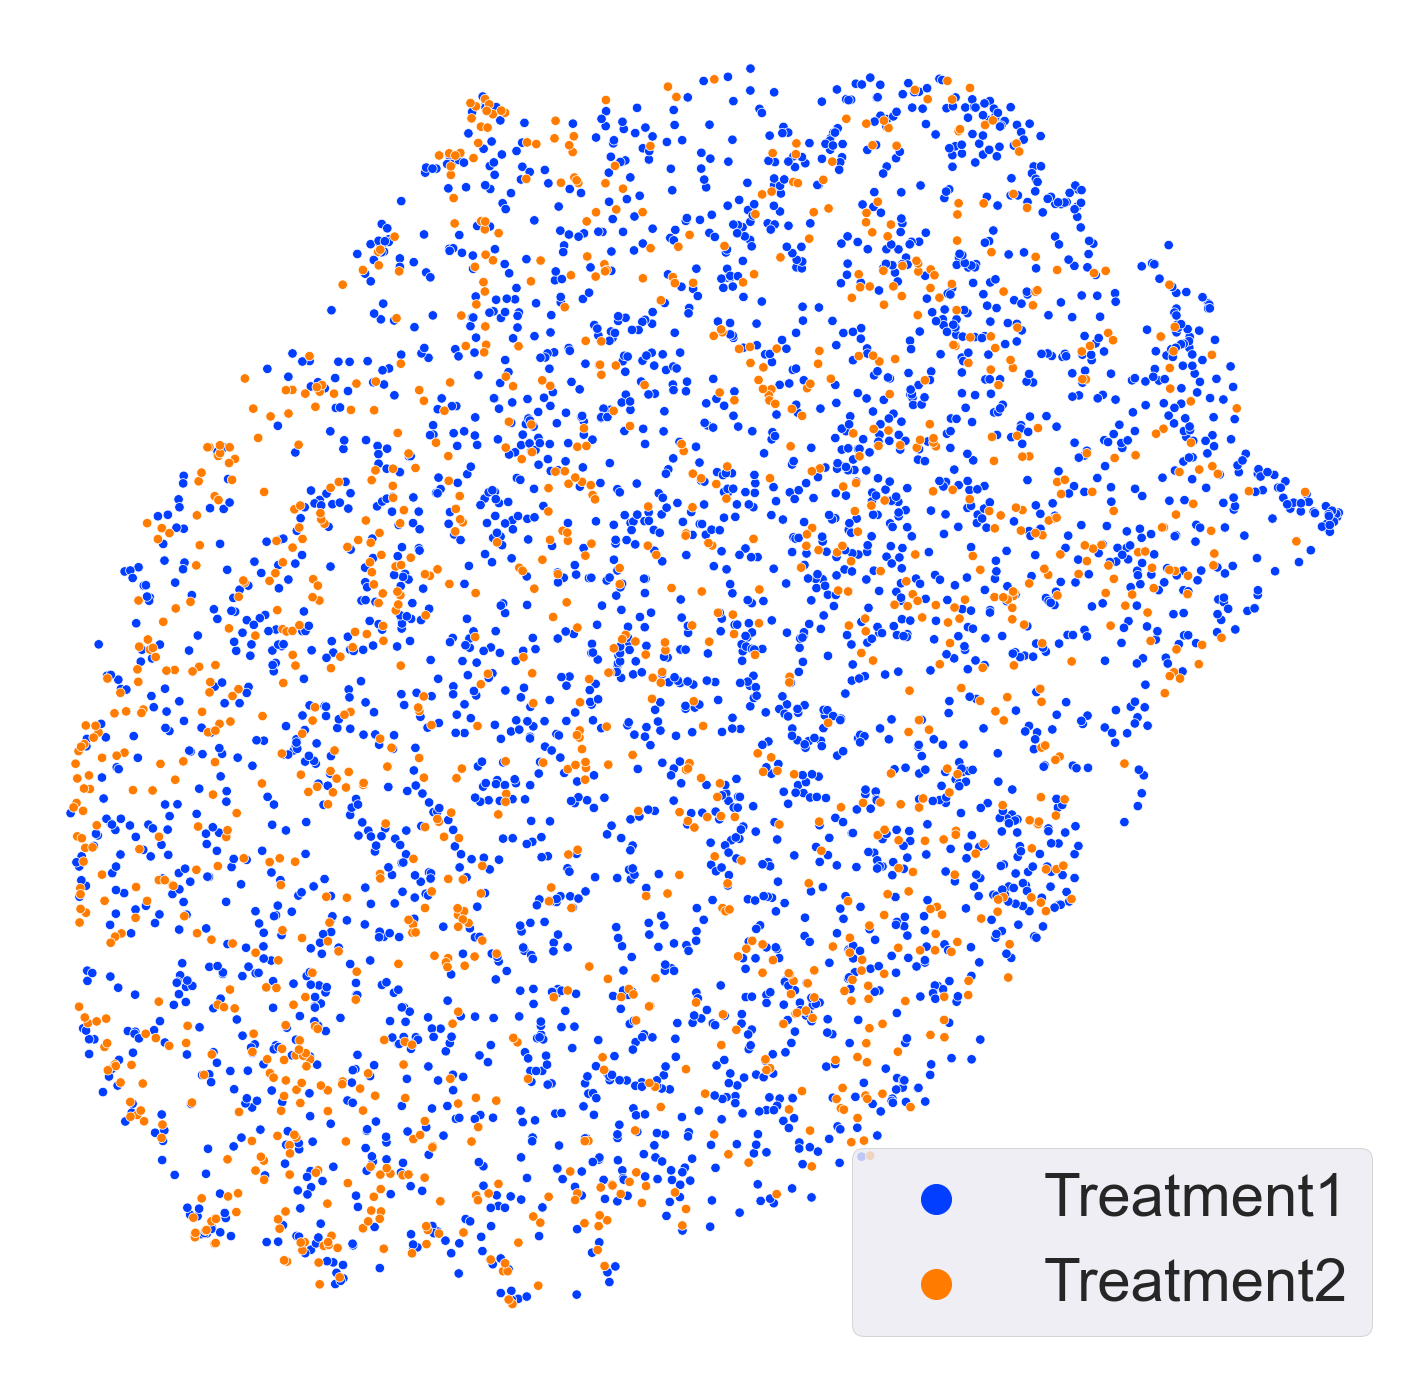

In [315]:
sns.set(font_scale = 5)

#data_real=np.hstack((embedding, labelAll[:]))
df1 = pd.DataFrame(embedding, columns=['col1','col2'])
df2 = pd.DataFrame(label1, columns=['ClassLabels1'])
df3 = pd.DataFrame(label2, columns=['ClassLabels2'])
df_F=pd.concat([df1, df2, df3],axis=1)

plt.figure(figsize=(25,25))
plt.axis('off')
sns.scatterplot(data=df_F, x="col1", y="col2", s=90, hue="ClassLabels1", palette=('bright'))
plt.legend(markerscale=5, fontsize=60)


In [316]:
import sklearn
sklearn.metrics.silhouette_score(embedding, label1, metric='euclidean', sample_size=None, random_state=None)

0.02191426

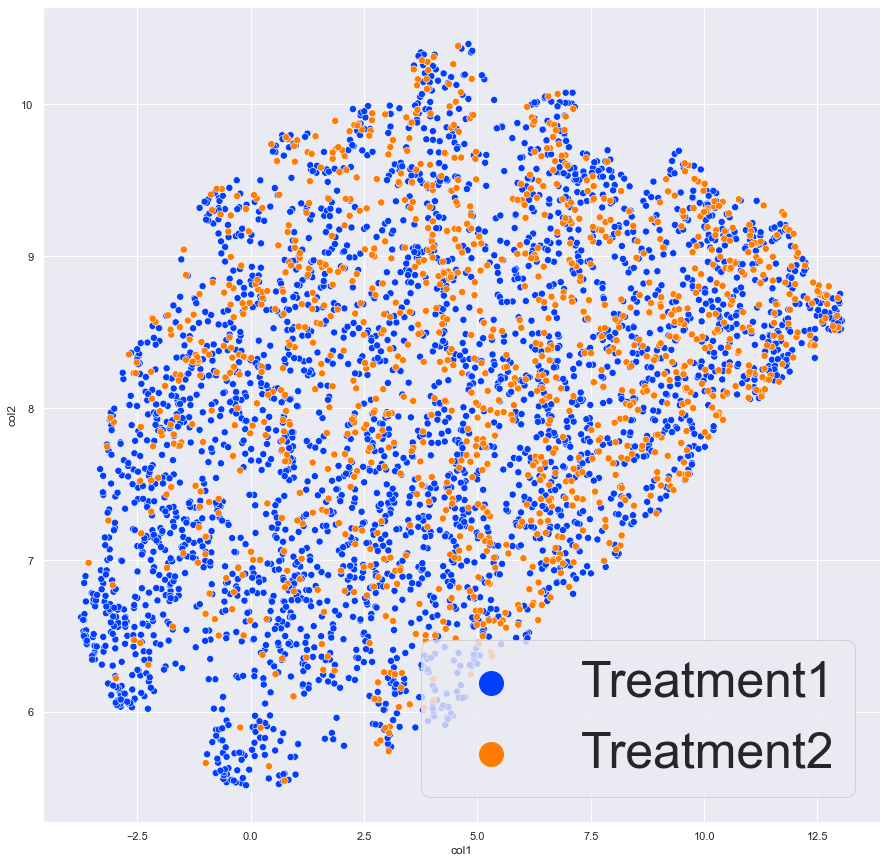

In [317]:

mu_gen_A=torch.vstack(mu_gen_All)
mu_gen_A=mu_gen_A.detach().numpy()

emb=dis_evaluator.reduce_latent2d(dis_evaluator.normalize_matrix(mu_gen_A), dim_red='umap')
df_F=[]
 
#data_real=np.hstack((embedding, labelAll[:]))
df1 = pd.DataFrame(emb, columns=['col1','col2'])
df2 = pd.DataFrame(label1, columns=['ClassLabels1'])
df3 = pd.DataFrame(label2, columns=['ClassLabels2'])
df_F=pd.concat([df1, df2, df3],axis=1)


plt.figure(figsize=(15,15))
sns.set(font_scale = 1)
sns.scatterplot(data=df_F, x="col1", y="col2", s=50, hue="ClassLabels1", palette=('bright'))
plt.legend(markerscale=4, fontsize=50)


In [109]:
import sklearn
sklearn.metrics.silhouette_score(embedding, label1, metric='euclidean', sample_size=None, random_state=None)

0.29517585

In [110]:
df_X = pd.DataFrame(mu_real_All)

df_z_scaled = df_X.copy()
for column in df_z_scaled.columns:
    df_z_scaled[column] = (df_z_scaled[column] - df_z_scaled[column].mean()) / (df_z_scaled[column].std())    
  

<AxesSubplot:>

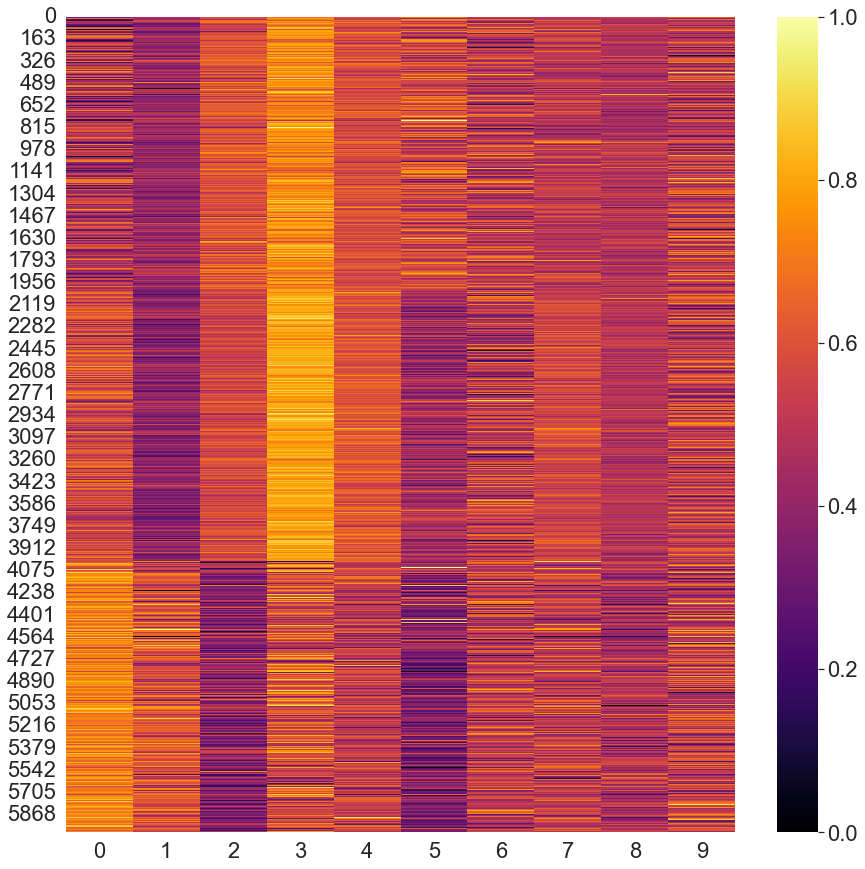

In [111]:
# copy the data
plt.figure(figsize=(15,15))

sns.set(font_scale = 2)


df_min_max_scaled = df_X.copy()
  
# apply normalization techniques
for column in df_min_max_scaled.columns:
    df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
sns.heatmap(df_min_max_scaled, cmap='inferno')

In [112]:
mu_real_All

array([[-0.23882198, -0.65003026,  1.6905593 , ...,  0.08281628,
        -0.10010321,  2.0601616 ],
       [-2.6954222 , -0.8331874 ,  1.4022094 , ...,  0.88406587,
         0.15189902,  0.67106915],
       [-1.3499184 , -1.4271369 ,  1.1089587 , ..., -1.1381971 ,
         0.49682468,  0.44977188],
       ...,
       [ 2.1351492 , -0.207894  , -2.5118082 , ...,  0.27365643,
        -0.05128915, -0.4511261 ],
       [ 0.5908959 , -0.26889676, -2.929725  , ...,  0.8227707 ,
         0.57136524, -0.05273508],
       [ 0.9107076 , -0.97547495, -0.69025576, ..., -0.6780379 ,
         0.32237214, -1.475659  ]], dtype=float32)

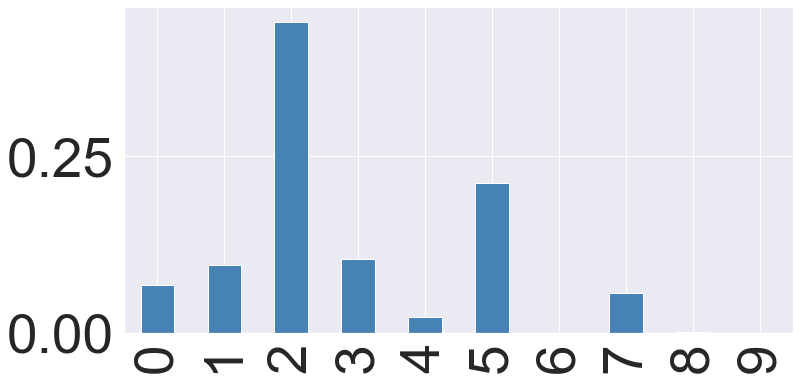

Accuracy: 0.8233333333333334


In [113]:
sns.set(font_scale=5)

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
plt.grid(None)
#plt.axis('off')
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(mu_real_All, df2, test_size=0.3, random_state=1)
clf = DecisionTreeClassifier(criterion='gini', max_depth=6)
clf.fit(X_train, y_train)  # celltype
pd.Series(clf.feature_importances_, index=df_X.columns).plot.bar(color='steelblue', figsize=(12, 6))
plt.show()
y_pred = clf.predict(X_test)


print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [114]:
df_min_max_scaled.loc[:,1]

0       0.442299
1       0.414055
2       0.322467
3       0.403699
4       0.441805
          ...   
5992    0.629824
5993    0.568488
5994    0.510477
5995    0.501070
5996    0.392114
Name: 1, Length: 5997, dtype: float32

C:\Users\Kevin Tsia\AppData\Local\Temp\ipykernel_18608\1777085143.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


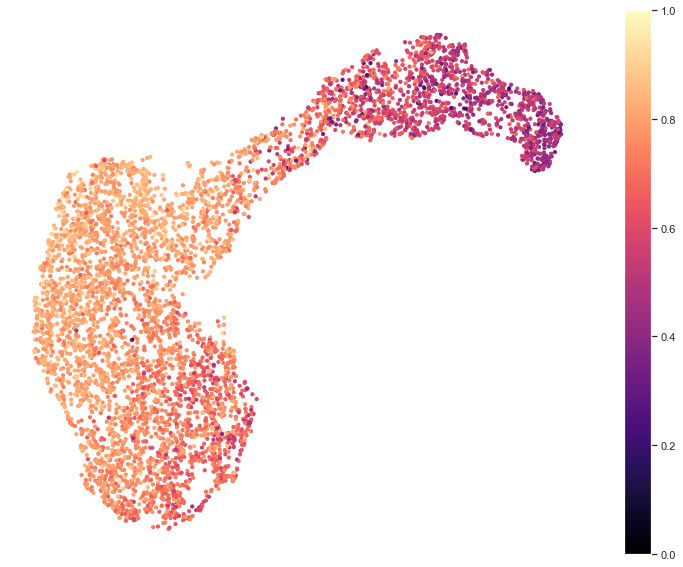

In [115]:

plt.figure(figsize=(13,10))
plt.grid(None)

sns.set(font_scale = 1)
b=plt.scatter(data=df_F, x="col1", y="col2", s=10, cmap='magma',  c=df_min_max_scaled.loc[:,3])
plt.colorbar()
plt.axis('off')

plt.show()


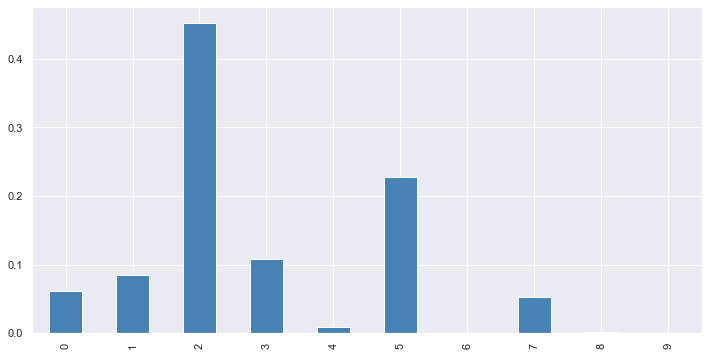

0.8010015509863214

In [116]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
#plt.axis('off')
X_train, X_test, y_train, y_test = train_test_split(mu_real_All, label1, test_size=0.3, random_state=1)
clf = DecisionTreeClassifier(criterion='gini', max_depth=5)
clf.fit(X_train, y_train)  # celltype
df_X=pd.DataFrame(mu_real_All)
pd.Series(clf.feature_importances_, index=df_X.columns).plot.bar(color='steelblue', figsize=(12, 6))
plt.show()
y_pred = clf.predict(X_test)

f1_score(y_test, y_pred, average='macro')

In [117]:
clf

DecisionTreeClassifier(max_depth=5)

In [211]:
f1_score(y_test, y_pred, average='macro')

0.5722567466614719

In [212]:
plt.figure(figsize=(10,10))
a=plt.scatter(data=df_F, x="col1", y="col2",s=10,cmap='jet', c=SortedFeatMat.Area)
plt.colorbar()
plt.show()

NameError: name 'SortedFeatMat' is not defined

<Figure size 720x720 with 0 Axes>

C:\Users\Kevin Tsia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (3).

<Figure size 1440x1440 with 0 Axes>

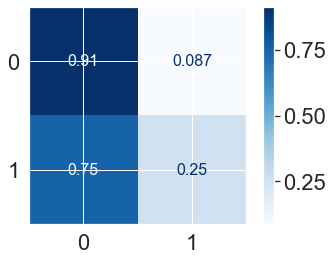

In [213]:
sns.set(font_scale=2)
plt.figure(figsize=(20,20))



import sklearn

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,plot_confusion_matrix
#X = mu_real_All
#class_names = (['A172', 'BV2', 'MCF7', 'SkBr3'])
class_names = (['H1975', 'H2170', 'H526'])


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(mu_real_All, label1, test_size=0.23, random_state=1)
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)


y_pred= clf.predict(X_test)

plt.rcParams.update({'font.size': 16})
disp = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true' , display_labels=class_names)
plt.axis('off')



In [ ]:
y_pred

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (4).

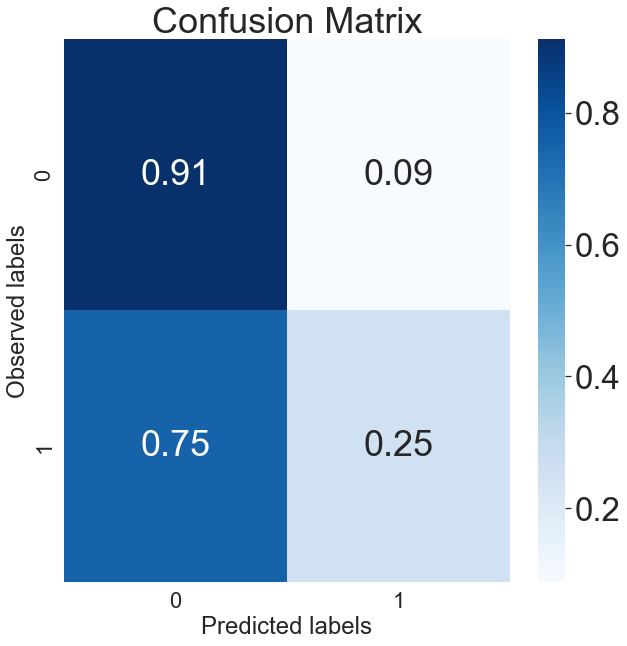

In [214]:
plt.figure(figsize=(10,10))

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit
cm=confusion_matrix(y_test, y_pred)
df=pd.DataFrame(cm)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cmn, annot=True, fmt='.2f', ax=ax, cmap="Blues");  # annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('Observed labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['A172', 'BV2', 'MCF7', 'SkBr3']);
ax.yaxis.set_ticklabels(['A172', 'BV2', 'MCF7', 'SkBr3']);
#ax.xaxis.set_ticklabels(['H1975', 'H2170', 'H526']);
#ax.yaxis.set_ticklabels(['H1975', 'H2170', 'H526']);

plt.show()

In [88]:
df

,0,1,2,3
0,627,0,14,0
1,0,966,27,77
2,35,2,486,56
3,0,45,105,317
